# House Price Prediction - Ensemble Conformal Quantile Regression Pipeline

## 1. Package Installation
*Install required machine learning libraries*

In [2]:
 !pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


## 2. Import Required Libraries
*Import essential data science and machine learning packages*

In [3]:
# 2: Import Libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import gc

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Data Loading and Memory Optimization
*Load datasets and optimize memory usage for efficient processing*

In [5]:
# 4: Data Loading and Memory Optimization
# This also remains the same.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

try:
    train_path = '/content/drive/MyDrive/House price/prediction-interval-competition-ii-house-price/dataset.csv'
    test_path = '/content/drive/MyDrive/House price/prediction-interval-competition-ii-house-price/test.csv'

    train_df_raw = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    train_df_raw = reduce_mem_usage(train_df_raw)
    test_df = reduce_mem_usage(test_df)

    print("Data loaded successfully and memory reduced.")

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    train_df_raw = pd.DataFrame()
    test_df = pd.DataFrame()

Mem. usage decreased to 24.99 Mb (65.2% reduction)
Mem. usage decreased to 24.22 Mb (65.5% reduction)
Data loaded successfully and memory reduced.


## 4. Exploratory Data Analysis (EDA)

### 4.1 Dataset Overview
*Examine dataset structure, dimensions, and basic information*

In [6]:
train_df_raw.shape

(200000, 47)

In [7]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 47 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                200000 non-null  int32  
 1   sale_date         200000 non-null  object 
 2   sale_price        200000 non-null  int32  
 3   sale_nbr          157818 non-null  float32
 4   sale_warning      200000 non-null  object 
 5   join_status       200000 non-null  object 
 6   join_year         200000 non-null  int16  
 7   latitude          200000 non-null  float32
 8   longitude         200000 non-null  float32
 9   area              200000 non-null  int8   
 10  city              200000 non-null  object 
 11  zoning            200000 non-null  object 
 12  subdivision       182450 non-null  object 
 13  present_use       200000 non-null  int8   
 14  land_val          200000 non-null  int32  
 15  imp_val           200000 non-null  int32  
 16  year_built        20

In [8]:
train_df_raw.head()

,id,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,...,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
0,0,2014-11-15,236000,2.0,,nochg,2025,47.291698,-122.365799,53,...,0,0,0,0,0,0,0,0,0,I
1,1,1999-01-15,313300,NaN,26,nochg,2025,47.653099,-122.199600,74,...,0,0,0,0,0,1,0,0,0,Q
2,2,2006-08-15,341000,1.0,,nochg,2025,47.473301,-122.190102,30,...,0,0,0,0,0,0,0,0,0,K
3,3,1999-12-15,267000,1.0,,nochg,2025,47.473900,-122.329498,96,...,0,0,0,0,0,0,0,0,0,G
4,4,2018-07-15,1650000,2.0,,miss99,2025,47.751598,-122.122200,36,...,0,0,0,0,0,0,0,0,0,P


### 4.2 Missing Values Analysis
*Identify and quantify missing data patterns*

In [9]:
missing_values = train_df_raw.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

,0
sale_nbr,42182
subdivision,17550
submarket,1717


In [10]:
# Optional: Example of filling missing values
# train_df_raw['LotFrontage'] = train_df_raw['LotFrontage'].fillna(train_df_raw['LotFrontage'].median())

### 4.3 Statistical Summary
*Generate descriptive statistics for numerical features*

In [11]:
train_df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
id,200000.0,99999.500000,57735.171256,0.000000,49999.750000,99999.500000,149999.250000,1.999990e+05
sale_price,200000.0,584149.494690,417059.519757,50293.000000,305000.000000,459950.000000,724950.000000,2.999950e+06
sale_nbr,157818.0,2.162599,1.113682,1.000000,1.000000,2.000000,3.000000,1.100000e+01
join_year,200000.0,2023.403600,6.241643,1999.000000,2025.000000,2025.000000,2025.000000,2.025000e+03
latitude,200000.0,47.549252,0.142708,47.155201,47.446499,47.562801,47.673500,4.777780e+01
longitude,200000.0,-122.210442,0.195292,-122.527702,-122.323799,-122.222702,-122.121696,-1.211613e+02
area,200000.0,48.644215,27.132002,1.000000,26.000000,48.000000,71.000000,1.000000e+02
present_use,200000.0,4.108860,7.199323,2.000000,2.000000,2.000000,2.000000,2.900000e+01
land_val,200000.0,460169.092410,351044.447775,0.000000,231000.000000,377000.000000,594000.000000,1.386400e+07
imp_val,200000.0,491771.491330,368050.501496,0.000000,280000.000000,409000.000000,599000.000000,1.006700e+07


### 4.4 Target Variable Distribution Analysis
*Analyze sale price distribution and log transformation*

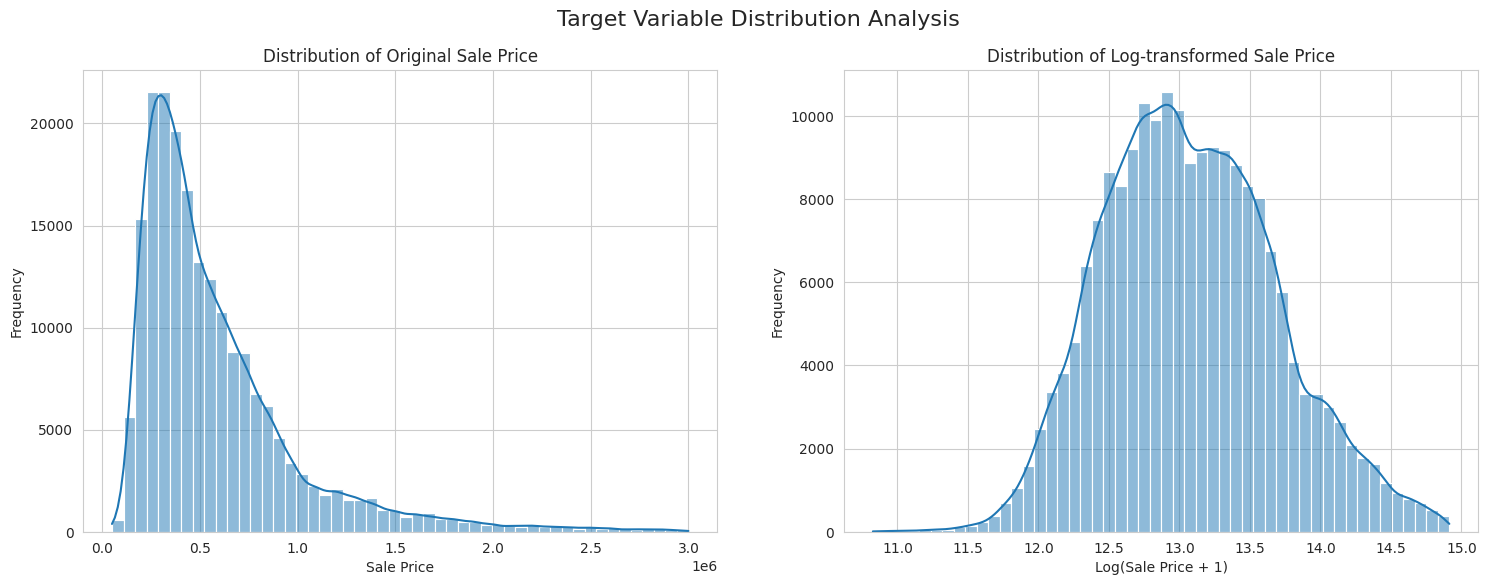

In [12]:
# 4: Exploratory Data Analysis (EDA) and Visualizations
if not train_df_raw.empty:
    # 5.1. Target Variable Analysis
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(train_df_raw['sale_price'], kde=True, bins=50)
    plt.title('Distribution of Original Sale Price')
    plt.xlabel('Sale Price')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(train_df_raw['sale_price']), kde=True, bins=50)
    plt.title('Distribution of Log-transformed Sale Price')
    plt.xlabel('Log(Sale Price + 1)')
    plt.ylabel('Frequency')

    plt.suptitle('Target Variable Distribution Analysis', fontsize=16)
    plt.show()

### 4.5 Categorical Features Analysis
*Examine unique value counts and categorical feature distributions*

In [13]:
# For categorical columns
train_df_raw.select_dtypes(include='object').nunique()

,0
sale_date,313
sale_warning,142
join_status,8
city,41
zoning,500
subdivision,10376
submarket,19


### 4.6 Outlier Detection
*Visualize outliers in target variable using boxplots*

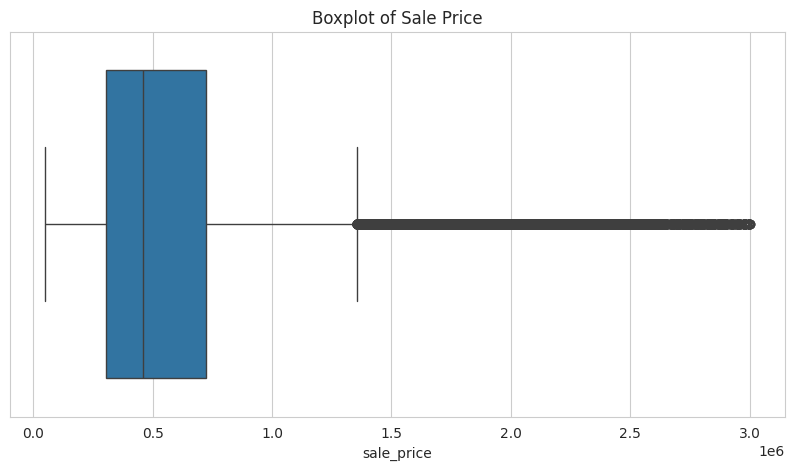

In [14]:
# Boxplot for outliers in Sale Price
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df_raw['sale_price'])
plt.title('Boxplot of Sale Price')
plt.show()

### 4.7 Feature Correlation Analysis
*Create correlation heatmap for numerical features*

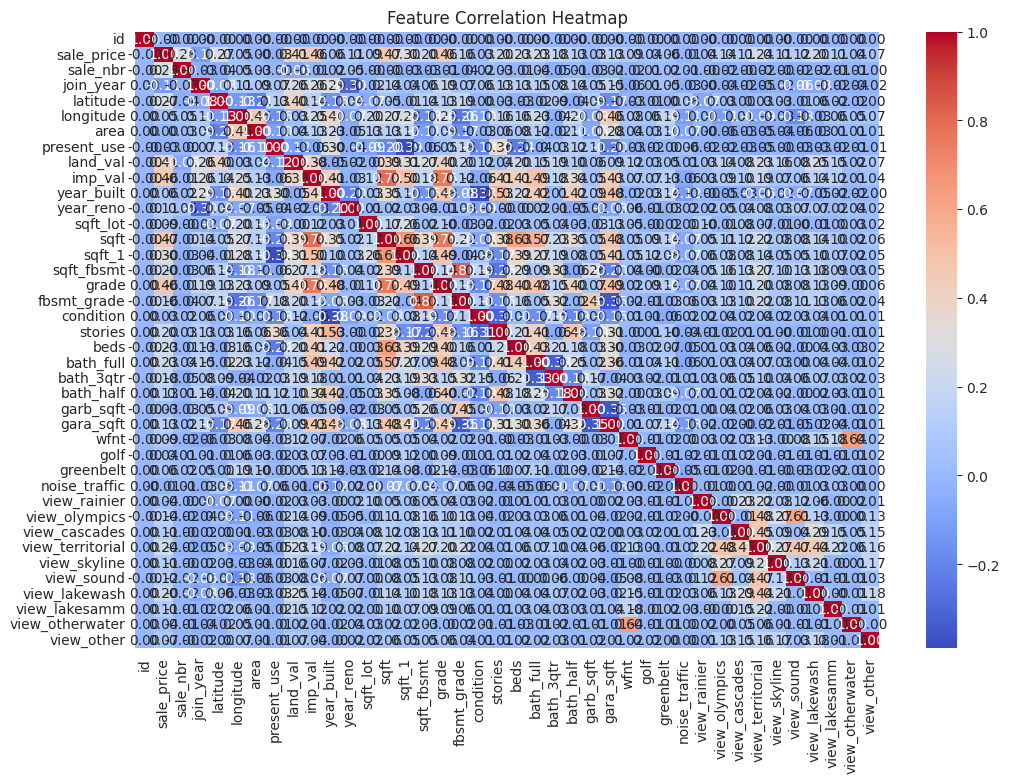

In [15]:
corr = train_df_raw.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

### 4.8 Feature Relationships Visualization
*Explore relationships between key features and target variable*

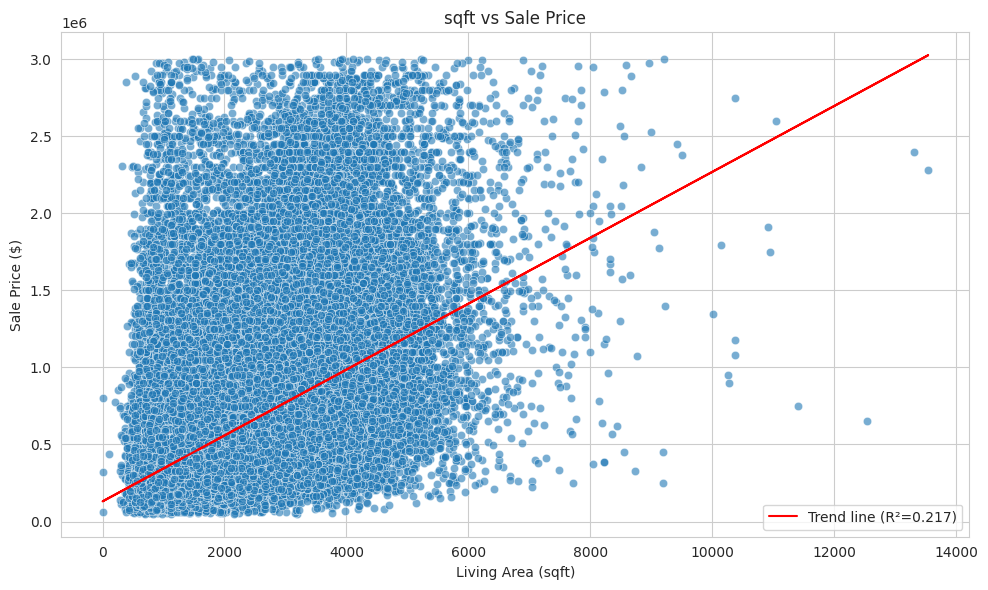

Correlation between sqft and sale_price: 0.466


In [16]:
# Scatterplot: Living Area vs SalePrice
if not train_df_raw.empty:
    # Check for different possible column names for living area
    possible_columns = ['sqft', 'gr_liv_area', 'GrLivArea', 'ground_living_area', 'GroundLivingArea', 'sqft_1']
    living_area_col = None

    for col in possible_columns:
        if col in train_df_raw.columns:
            living_area_col = col
            break

    if living_area_col is not None and 'sale_price' in train_df_raw.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=train_df_raw[living_area_col], y=train_df_raw['sale_price'], alpha=0.6)
        plt.title(f'{living_area_col} vs Sale Price')
        plt.xlabel('Living Area (sqft)')
        plt.ylabel('Sale Price ($)')

        # Add a trend line for better visualization
        import scipy.stats as stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(train_df_raw[living_area_col], train_df_raw['sale_price'])
        line = slope * train_df_raw[living_area_col] + intercept
        plt.plot(train_df_raw[living_area_col], line, 'r', label=f'Trend line (R²={r_value**2:.3f})')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"Correlation between {living_area_col} and sale_price: {train_df_raw[living_area_col].corr(train_df_raw['sale_price']):.3f}")
    else:
        print("Error: Required columns not found in the dataset.")
        print("Available columns:", list(train_df_raw.columns))
        if living_area_col is None:
            print("Living area column not found. Tried:", possible_columns)
        if 'sale_price' not in train_df_raw.columns:
            print("Sale price column not found.")
else:
    print("Training data is empty. Cannot create scatterplot.")

### 4.9 Correlation Analysis with Log-Transformed Target
*Identify top features correlated with log-transformed sale price*

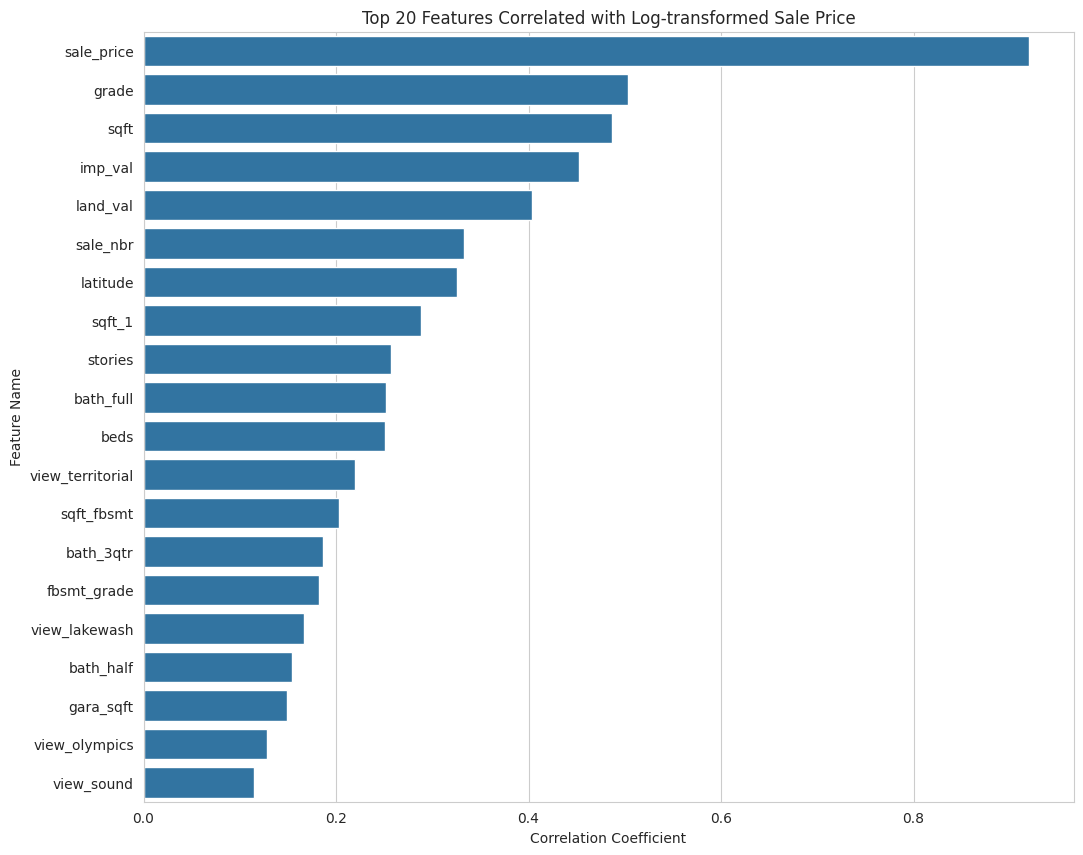

In [17]:
    # 4.2. Correlation Analysis
    df_train_for_corr = train_df_raw.copy()
    df_train_for_corr['log_sale_price'] = np.log1p(df_train_for_corr['sale_price'])

    corr_matrix = df_train_for_corr.select_dtypes(include=np.number).corr()

    top_corr_features = corr_matrix['log_sale_price'].abs().sort_values(ascending=False).index[1:21]

    plt.figure(figsize=(12, 10))
    sns.barplot(x=corr_matrix['log_sale_price'][top_corr_features], y=top_corr_features)
    plt.title('Top 20 Features Correlated with Log-transformed Sale Price')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Feature Name')
    plt.show()

### 4.9 Advanced Feature Distribution Analysis
*Analyze distributions of key numerical features with statistical insights*

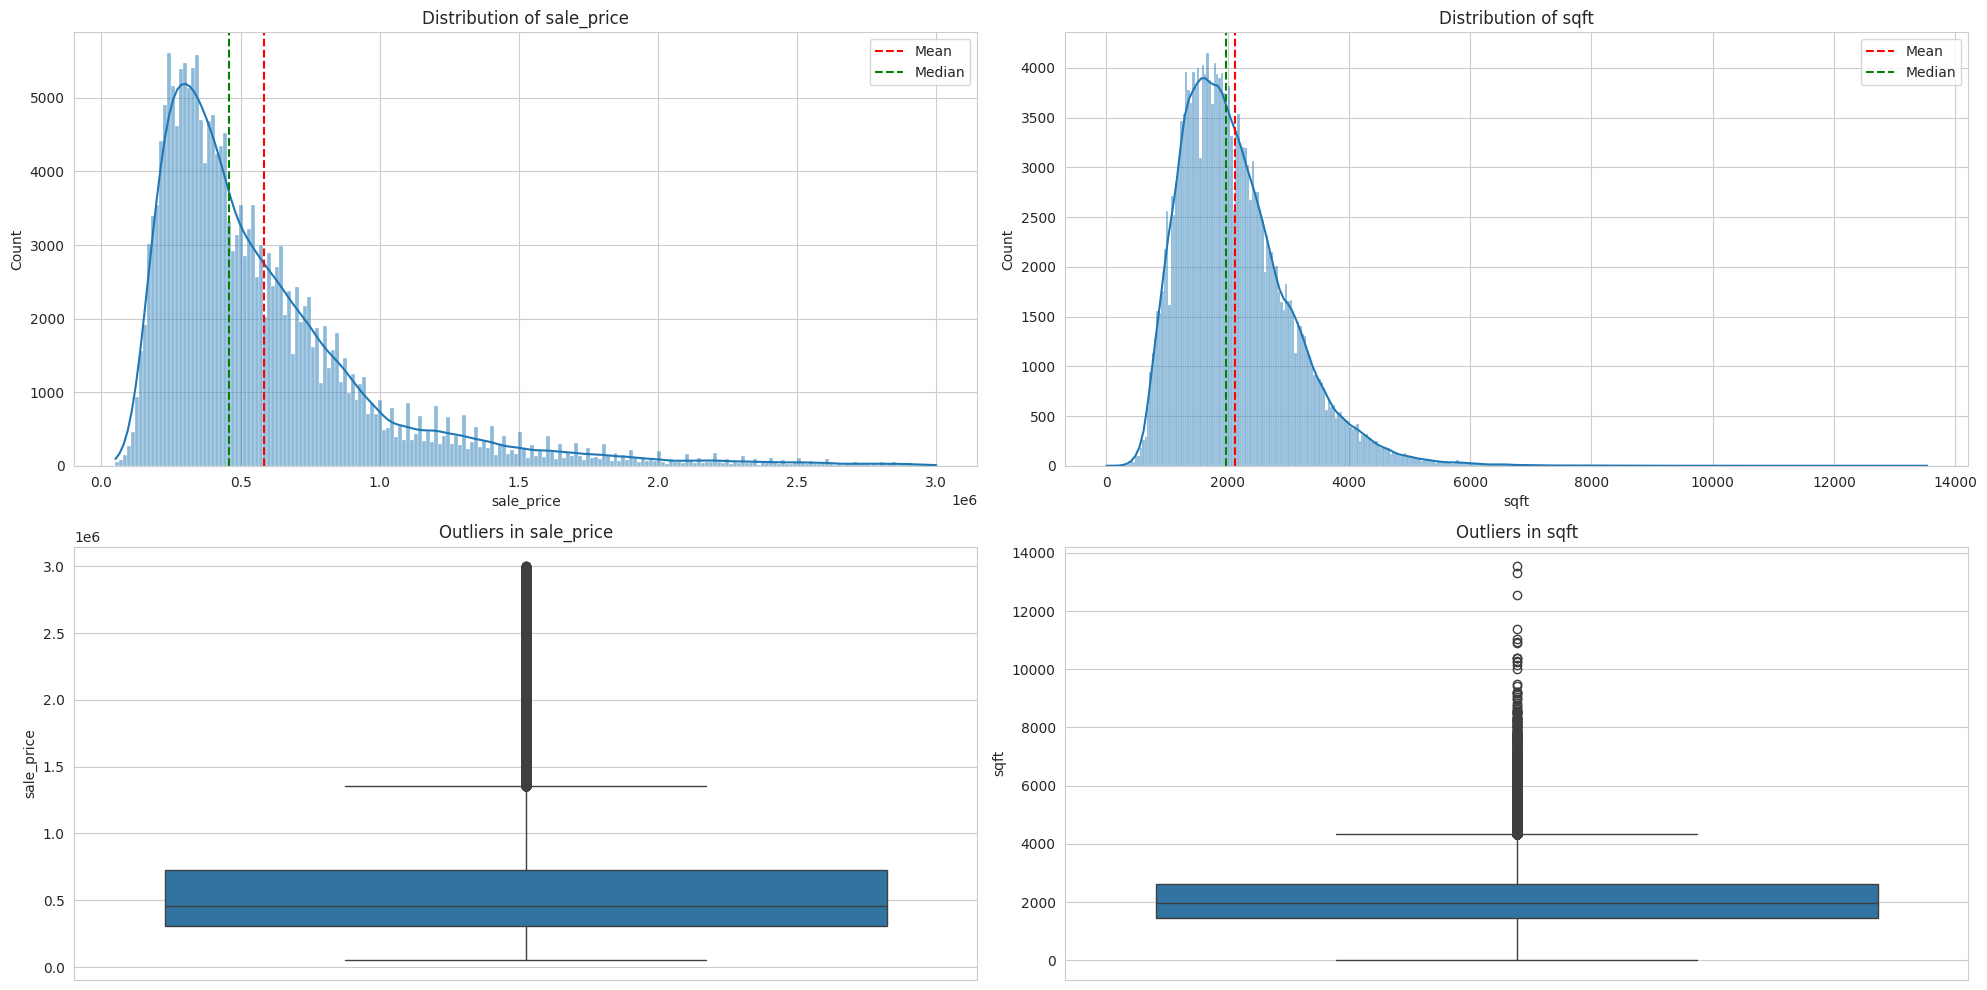

=== Statistical Summary of Key Features ===
       sale_price       sqft
count   200000.00  200000.00
mean    584149.49    2120.68
std     417059.52     909.80
min      50293.00       0.00
25%     305000.00    1460.00
50%     459950.00    1970.00
75%     724950.00    2610.00
max    2999950.00   13540.00


In [18]:
# 4.9: Advanced Feature Distribution Analysis
if not train_df_raw.empty:
    # Select top numerical features for detailed analysis
    numerical_cols = train_df_raw.select_dtypes(include=[np.number]).columns
    key_features = ['sale_price', 'sqft', 'bedrooms', 'bathrooms', 'floors']

    # Filter features that exist in the dataset
    available_features = [col for col in key_features if col in numerical_cols]

    if len(available_features) > 1:
        fig, axes = plt.subplots(2, len(available_features), figsize=(20, 10))

        for i, feature in enumerate(available_features):
            # Distribution plot
            sns.histplot(train_df_raw[feature], kde=True, ax=axes[0, i])
            axes[0, i].set_title(f'Distribution of {feature}')
            axes[0, i].axvline(train_df_raw[feature].mean(), color='red', linestyle='--', label='Mean')
            axes[0, i].axvline(train_df_raw[feature].median(), color='green', linestyle='--', label='Median')
            axes[0, i].legend()

            # Box plot for outlier detection
            sns.boxplot(y=train_df_raw[feature], ax=axes[1, i])
            axes[1, i].set_title(f'Outliers in {feature}')

        plt.tight_layout()
        plt.show()

        # Statistical summary
        print("=== Statistical Summary of Key Features ===")
        print(train_df_raw[available_features].describe().round(2))

### 4.10 Geographic and Categorical Analysis
*Explore categorical features and their relationship with target variable*

Available categorical columns: ['sale_date', 'sale_warning', 'join_status', 'city', 'zoning', 'subdivision', 'submarket']
Found predefined categorical columns: ['city', 'zoning']
Created plot for city with 10 categories
Created plot for zoning with 10 categories


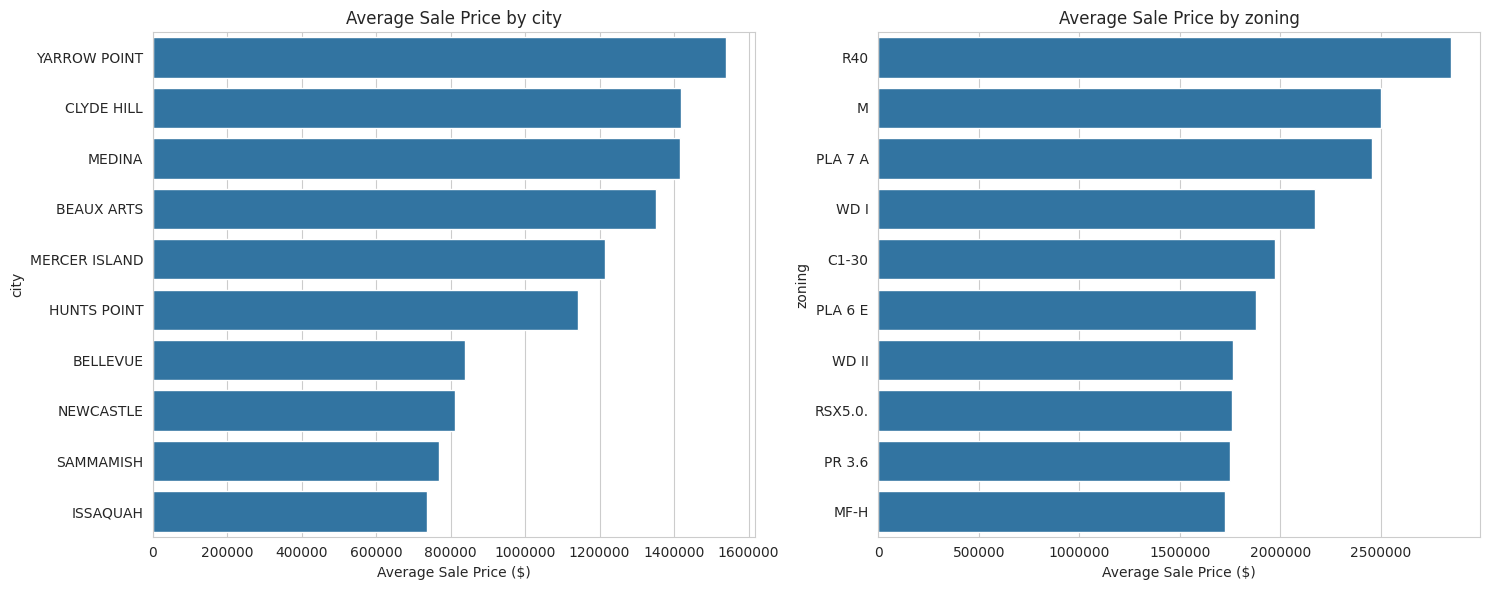

In [19]:
# 4.10: Categorical Features Analysis
if not train_df_raw.empty:
    categorical_cols = train_df_raw.select_dtypes(include=['object']).columns
    print(f"Available categorical columns: {list(categorical_cols)}")

    # First, let's see what categorical columns we actually have
    if len(categorical_cols) == 0:
        print("No categorical columns found in the dataset.")
        print("Available columns:", list(train_df_raw.columns))
    else:
        # Use actual categorical columns from the dataset instead of predefined ones
        key_categorical = ['property_type', 'neighborhood', 'condition', 'grade', 'city', 'zoning', 'present_use']
        available_categorical = [col for col in key_categorical if col in categorical_cols]

        # If predefined categories don't exist, use the first few available categorical columns
        if len(available_categorical) == 0:
            available_categorical = list(categorical_cols)[:4]  # Take first 4 categorical columns
            print(f"Using available categorical columns: {available_categorical}")
        else:
            print(f"Found predefined categorical columns: {available_categorical}")

        if len(available_categorical) > 0:
            n_cols = min(2, len(available_categorical))
            n_rows = (len(available_categorical) + n_cols - 1) // n_cols  # Ceiling division

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6*n_rows))

            # Handle different subplot configurations
            if n_rows == 1 and n_cols == 1:
                axes = [axes]  # Single subplot case
            elif n_rows == 1:
                axes = axes.reshape(1, -1)  # Single row, multiple columns
            elif n_cols == 1:
                axes = axes.reshape(-1, 1)  # Single column, multiple rows

            # Flatten axes for easier indexing
            axes_flat = axes.flatten() if len(available_categorical) > 1 else [axes[0]]

            for i, feature in enumerate(available_categorical[:4]):  # Limit to 4 features
                if i < len(axes_flat):  # Safety check
                    ax = axes_flat[i]

                    try:
                        # Check if feature has valid data
                        if feature in train_df_raw.columns and not train_df_raw[feature].isna().all():
                            # Calculate mean sale price by category
                            category_stats = train_df_raw.groupby(feature)['sale_price'].agg(['mean', 'count']).reset_index()
                            category_stats = category_stats.sort_values('mean', ascending=False).head(10)

                            if not category_stats.empty:
                                sns.barplot(data=category_stats, x='mean', y=feature, ax=ax)
                                ax.set_title(f'Average Sale Price by {feature}')
                                ax.set_xlabel('Average Sale Price ($)')

                                # Format x-axis labels for better readability
                                ax.ticklabel_format(style='plain', axis='x')

                                print(f"Created plot for {feature} with {len(category_stats)} categories")
                            else:
                                ax.text(0.5, 0.5, f'No data for {feature}',
                                       horizontalalignment='center', verticalalignment='center',
                                       transform=ax.transAxes)
                                ax.set_title(f'{feature} (No Data)')
                        else:
                            ax.text(0.5, 0.5, f'{feature} not found or empty',
                                   horizontalalignment='center', verticalalignment='center',
                                   transform=ax.transAxes)
                            ax.set_title(f'{feature} (Not Found)')

                    except Exception as e:
                        print(f"Error processing {feature}: {str(e)}")
                        ax.text(0.5, 0.5, f'Error: {feature}',
                               horizontalalignment='center', verticalalignment='center',
                               transform=ax.transAxes)
                        ax.set_title(f'{feature} (Error)')

            # Remove empty subplots if any
            for i in range(len(available_categorical), len(axes_flat)):
                axes_flat[i].set_visible(False)

            plt.tight_layout()
            plt.show()
        else:
            print("No suitable categorical columns found for analysis.")
else:
    print("Training data is empty. Cannot perform categorical analysis.")

### 4.11 Statistical Hypothesis Testing
*Perform statistical tests to validate feature relationships*

In [20]:
# 4.11: Statistical Testing and Feature Validation
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway

if not train_df_raw.empty:
    print("=== Statistical Hypothesis Testing ===\n")

    # 1. Normality test for sale price
    _, p_value_normal = stats.shapiro(train_df_raw['sale_price'].sample(5000))  # Sample for large datasets
    print(f"Sale Price Normality Test (Shapiro-Wilk): p-value = {p_value_normal:.6f}")
    print(f"Sale Price is {'normally' if p_value_normal > 0.05 else 'not normally'} distributed\n")

    # 2. Correlation significance tests
    numerical_features = train_df_raw.select_dtypes(include=[np.number]).columns
    significant_correlations = []

    for feature in numerical_features:
        if feature != 'sale_price':
            corr_coef, p_value = stats.pearsonr(train_df_raw[feature].dropna(),
                                              train_df_raw.loc[train_df_raw[feature].notna(), 'sale_price'])
            if p_value < 0.05 and abs(corr_coef) > 0.1:
                significant_correlations.append((feature, corr_coef, p_value))

    significant_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    print("Top 10 Statistically Significant Correlations with Sale Price:")
    for feature, corr, p_val in significant_correlations[:10]:
        print(f"{feature}: r={corr:.3f}, p-value={p_val:.6f}")

=== Statistical Hypothesis Testing ===

Sale Price Normality Test (Shapiro-Wilk): p-value = 0.000000
Sale Price is not normally distributed

Top 10 Statistically Significant Correlations with Sale Price:
sqft: r=0.466, p-value=0.000000
grade: r=0.464, p-value=0.000000
imp_val: r=0.455, p-value=0.000000
land_val: r=0.412, p-value=0.000000
sqft_1: r=0.304, p-value=0.000000
sale_nbr: r=0.278, p-value=0.000000
latitude: r=0.273, p-value=0.000000
view_territorial: r=0.236, p-value=0.000000
bath_full: r=0.226, p-value=0.000000
beds: r=0.225, p-value=0.000000


### 4.12 Temporal Analysis and Market Trends
*Analyze price trends over time and seasonal patterns*

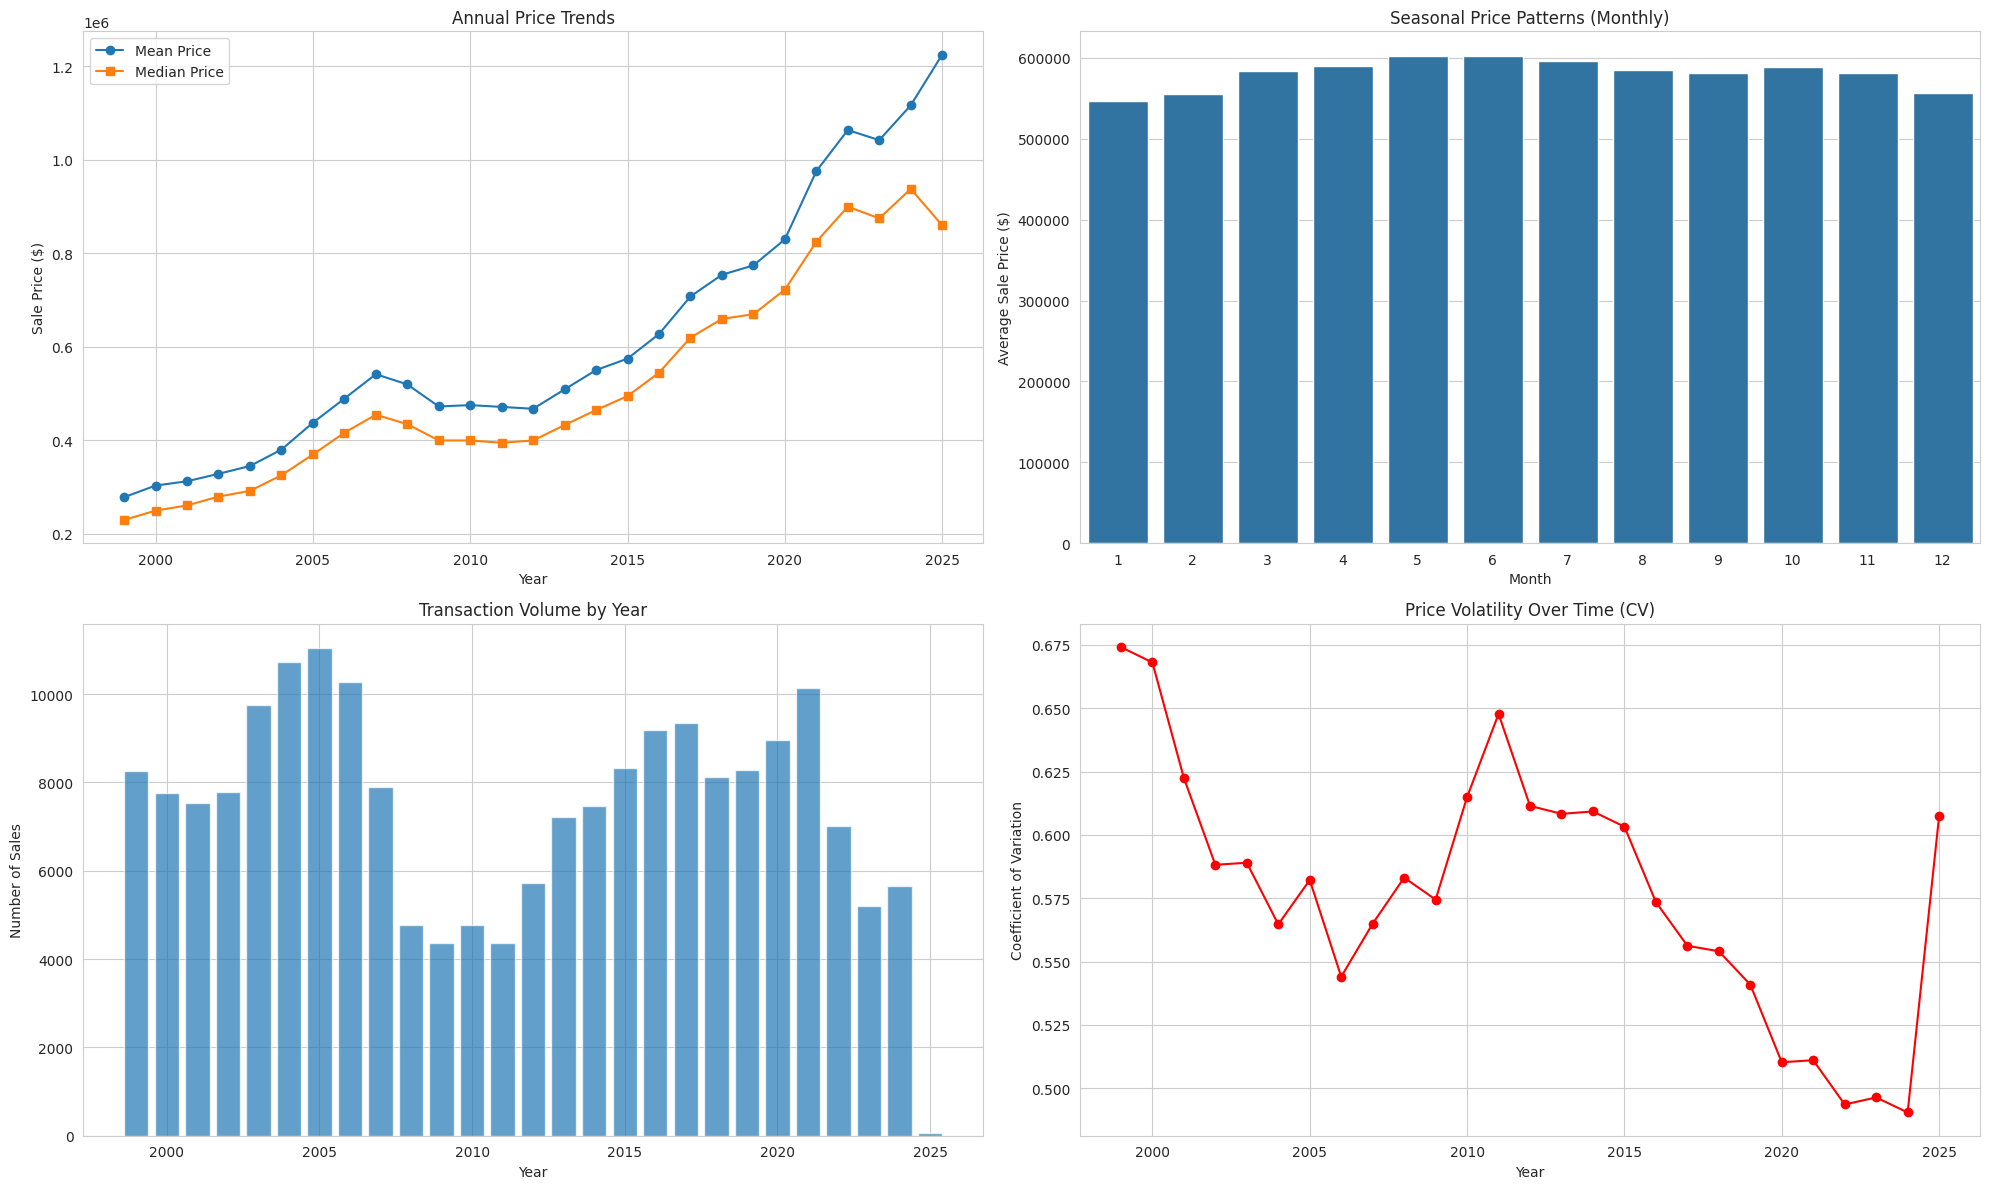

In [21]:
# 4.12: Time Series Analysis
if not train_df_raw.empty and 'sale_date' in train_df_raw.columns:
    # Prepare temporal data
    temp_df = train_df_raw.copy()
    temp_df['sale_date'] = pd.to_datetime(temp_df['sale_date'], errors='coerce')
    temp_df = temp_df.dropna(subset=['sale_date'])

    # Monthly and yearly trends
    temp_df['year'] = temp_df['sale_date'].dt.year
    temp_df['month'] = temp_df['sale_date'].dt.month
    temp_df['quarter'] = temp_df['sale_date'].dt.quarter

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # Yearly trend
    yearly_trend = temp_df.groupby('year')['sale_price'].agg(['mean', 'median', 'count']).reset_index()
    axes[0, 0].plot(yearly_trend['year'], yearly_trend['mean'], marker='o', label='Mean Price')
    axes[0, 0].plot(yearly_trend['year'], yearly_trend['median'], marker='s', label='Median Price')
    axes[0, 0].set_title('Annual Price Trends')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Sale Price ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Monthly seasonality
    monthly_trend = temp_df.groupby('month')['sale_price'].mean().reset_index()
    sns.barplot(data=monthly_trend, x='month', y='sale_price', ax=axes[0, 1])
    axes[0, 1].set_title('Seasonal Price Patterns (Monthly)')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Average Sale Price ($)')

    # Transaction volume over time
    axes[1, 0].bar(yearly_trend['year'], yearly_trend['count'], alpha=0.7)
    axes[1, 0].set_title('Transaction Volume by Year')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Number of Sales')

    # Price volatility (coefficient of variation)
    yearly_volatility = temp_df.groupby('year')['sale_price'].std() / temp_df.groupby('year')['sale_price'].mean()
    axes[1, 1].plot(yearly_volatility.index, yearly_volatility.values, marker='o', color='red')
    axes[1, 1].set_title('Price Volatility Over Time (CV)')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Coefficient of Variation')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

## 5. Advanced Missing Value Analysis and Handling
*Comprehensive missing value treatment strategy*::

=== Before Missing Value Handling ===
Total columns with missing values: 3

Top 10 columns with missing values:
         column  missing_percentage    dtype
3      sale_nbr             21.0910  float32
12  subdivision              8.7750   object
46    submarket              0.8585   object
=== Missing Value Handling Strategy ===

Handling sale_nbr: 21.09% missing
  -> Created missing indicator + filled with median

Handling subdivision: 8.77% missing
  -> Created 'Missing' category

Handling submarket: 0.86% missing
  -> Filled with mode: K

=== After Missing Value Handling ===
Remaining columns with missing values: 0

=== Applying to Test Set ===
=== Missing Value Handling Strategy ===

Handling sale_nbr: 21.21% missing
  -> Created missing indicator + filled with median

Handling subdivision: 8.77% missing
  -> Created 'Missing' category

Handling submarket: 0.86% missing
  -> Filled with mode: K


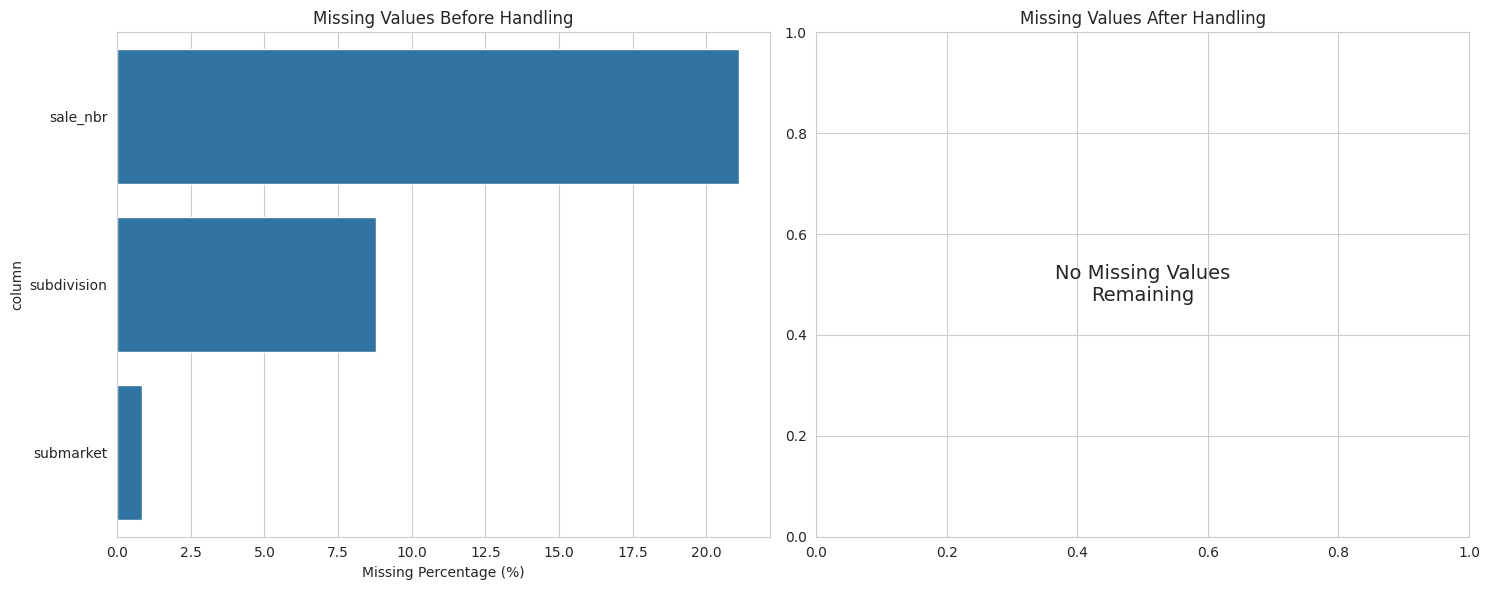

In [22]:
# 5.1: Missing Value Analysis
def analyze_missing_values(df):
    """Comprehensive missing value analysis"""
    missing_stats = []

    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        dtype = str(df[col].dtype)
        unique_count = df[col].nunique()

        missing_stats.append({
            'column': col,
            'missing_count': missing_count,
            'missing_percentage': missing_pct,
            'dtype': dtype,
            'unique_values': unique_count
        })

    missing_df = pd.DataFrame(missing_stats)
    missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_percentage', ascending=False)

    return missing_df

def advanced_missing_value_handler(df, strategy='auto'):
    """
    Advanced missing value handling with multiple strategies
    """
    df_copy = df.copy()

    # Get missing value statistics
    missing_analysis = analyze_missing_values(df_copy)

    if len(missing_analysis) == 0:
        print("No missing values found in the dataset.")
        return df_copy, {}

    handling_log = {}

    print("=== Missing Value Handling Strategy ===")

    for _, row in missing_analysis.iterrows():
        col = row['column']
        missing_pct = row['missing_percentage']
        dtype = row['dtype']

        print(f"\nHandling {col}: {missing_pct:.2f}% missing")

        if missing_pct > 50:
            # Drop columns with >50% missing values
            print(f"  -> Dropping {col} (>50% missing)")
            df_copy = df_copy.drop(columns=[col])
            handling_log[col] = 'dropped'

        elif 'object' in dtype or 'category' in dtype:
            # Categorical variables
            if missing_pct < 5:
                # Use mode for low missing percentage
                mode_val = df_copy[col].mode().iloc[0] if len(df_copy[col].mode()) > 0 else 'Unknown'
                df_copy[col] = df_copy[col].fillna(mode_val)
                handling_log[col] = f'mode_fill: {mode_val}'
                print(f"  -> Filled with mode: {mode_val}")
            else:
                # Create 'missing' category for higher missing percentage
                df_copy[col] = df_copy[col].fillna('Missing')
                handling_log[col] = 'missing_category'
                print(f"  -> Created 'Missing' category")

        else:
            # Numerical variables
            if missing_pct < 5:
                # Use median for low missing percentage
                median_val = df_copy[col].median()
                df_copy[col] = df_copy[col].fillna(median_val)
                handling_log[col] = f'median_fill: {median_val}'
                print(f"  -> Filled with median: {median_val:.2f}")

            elif missing_pct < 20:
                # Use advanced imputation for moderate missing percentage
                from sklearn.impute import KNNImputer

                # Select numerical columns for KNN imputation
                num_cols = df_copy.select_dtypes(include=[np.number]).columns
                if len(num_cols) > 1:
                    knn_imputer = KNNImputer(n_neighbors=5)
                    df_copy[num_cols] = knn_imputer.fit_transform(df_copy[num_cols])
                    handling_log[col] = 'knn_imputation'
                    print(f"  -> Applied KNN imputation")
                else:
                    median_val = df_copy[col].median()
                    df_copy[col] = df_copy[col].fillna(median_val)
                    handling_log[col] = f'median_fill: {median_val}'
                    print(f"  -> Filled with median: {median_val:.2f}")
            else:
                # Create missing indicator for high missing percentage
                df_copy[f'{col}_was_missing'] = df_copy[col].isnull().astype(int)
                median_val = df_copy[col].median()
                df_copy[col] = df_copy[col].fillna(median_val)
                handling_log[col] = f'missing_indicator + median: {median_val}'
                print(f"  -> Created missing indicator + filled with median")

    return df_copy, handling_log

# Apply enhanced missing value handling
if not train_df_raw.empty:
    print("=== Before Missing Value Handling ===")
    initial_missing = analyze_missing_values(train_df_raw)
    if len(initial_missing) > 0:
        print(f"Total columns with missing values: {len(initial_missing)}")
        print("\nTop 10 columns with missing values:")
        print(initial_missing.head(10)[['column', 'missing_percentage', 'dtype']])

        # Apply advanced missing value handling
        train_df_cleaned, missing_log = advanced_missing_value_handler(train_df_raw, strategy='auto')

        print("\n=== After Missing Value Handling ===")
        final_missing = analyze_missing_values(train_df_cleaned)
        print(f"Remaining columns with missing values: {len(final_missing)}")

        # Update the train_df_raw with cleaned data
        train_df_raw = train_df_cleaned

        # Apply same handling to test set
        print("\n=== Applying to Test Set ===")
        test_df_cleaned, _ = advanced_missing_value_handler(test_df, strategy='auto')
        test_df = test_df_cleaned

        # Visualization of missing value patterns
        if len(initial_missing) > 0:
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            # Before handling
            before_missing = initial_missing.head(10)
            sns.barplot(data=before_missing, x='missing_percentage', y='column', ax=axes[0])
            axes[0].set_title('Missing Values Before Handling')
            axes[0].set_xlabel('Missing Percentage (%)')

            # After handling
            if len(final_missing) > 0:
                after_missing = final_missing.head(10)
                sns.barplot(data=after_missing, x='missing_percentage', y='column', ax=axes[1])
                axes[1].set_title('Missing Values After Handling')
                axes[1].set_xlabel('Missing Percentage (%)')
            else:
                axes[1].text(0.5, 0.5, 'No Missing Values\nRemaining',
                            horizontalalignment='center', verticalalignment='center',
                            transform=axes[1].transAxes, fontsize=14)
                axes[1].set_title('Missing Values After Handling')

            plt.tight_layout()
            plt.show()
    else:
        print("No missing values found in the training dataset.")

## 5. Define Evaluation Metrics (Winkler Score)

*Implement scoring functions for prediction interval evaluation*

In [23]:
# 5: Local Validation Metric (Winkler Score) - CORRECTED VERSION
def winkler_score(y_true, lower, upper, alpha=0.1):
    """
    Calculate Winkler Score for a single prediction interval.

    Standard Formula:
    WS = (upper - lower) + (2/α) * (lower - y_true) * I(y_true < lower) +
         (2/α) * (y_true - upper) * I(y_true > upper)

    Parameters:
    -----------
    y_true : float
        True value
    lower : float
        Lower bound of prediction interval
    upper : float
        Upper bound of prediction interval
    alpha : float
        Significance level (e.g., 0.1 for 90% intervals)

    Returns:
    --------
    float : Winkler score (lower is better)
    """
    # Base interval width
    interval_width = upper - lower

    # Penalty for under-coverage (y_true outside interval)
    penalty = 0.0

    if y_true < lower:
        # Penalty when true value is below lower bound
        penalty = (2.0 / alpha) * (lower - y_true)
    elif y_true > upper:
        # Penalty when true value is above upper bound
        penalty = (2.0 / alpha) * (y_true - upper)

    # Total Winkler score
    winkler_score = interval_width + penalty

    return winkler_score

def mean_winkler_score(y_true, lower, upper, alpha=0.1):
    """
    Calculate Mean Winkler Score across multiple predictions.

    Parameters:
    -----------
    y_true : array-like
        True values
    lower : array-like
        Lower bounds of prediction intervals
    upper : array-like
        Upper bounds of prediction intervals
    alpha : float
        Significance level

    Returns:
    --------
    float : Mean Winkler score
    """
    scores = [winkler_score(yt, l, u, alpha) for yt, l, u in zip(y_true, lower, upper)]
    return np.mean(scores)

# Validate the implementation
def validate_winkler_score():
    """Test function to validate Winkler score implementation"""
    print("=== Winkler Score Validation ===")

    # Test case 1: Perfect prediction (true value in center)
    score1 = winkler_score(y_true=100, lower=90, upper=110, alpha=0.1)
    print(f"Test 1 - Perfect center prediction: {score1:.2f} (Expected: 20.0)")

    # Test case 2: True value below interval
    score2 = winkler_score(y_true=80, lower=90, upper=110, alpha=0.1)
    print(f"Test 2 - Below interval: {score2:.2f} (Expected: 220.0)")

    # Test case 3: True value above interval
    score3 = winkler_score(y_true=120, lower=90, upper=110, alpha=0.1)
    print(f"Test 3 - Above interval: {score3:.2f} (Expected: 220.0)")

    # Test case 4: Multiple predictions
    y_test = [100, 80, 120, 95, 105]
    lower_test = [90, 90, 90, 90, 90]
    upper_test = [110, 110, 110, 110, 110]
    mean_score = mean_winkler_score(y_test, lower_test, upper_test, alpha=0.1)
    print(f"Test 4 - Mean score: {mean_score:.2f}")

    print("✓ Winkler Score implementation validated\n")

# Run validation
validate_winkler_score()

=== Winkler Score Validation ===
Test 1 - Perfect center prediction: 20.00 (Expected: 20.0)
Test 2 - Below interval: 220.00 (Expected: 220.0)
Test 3 - Above interval: 220.00 (Expected: 220.0)
Test 4 - Mean score: 100.00
✓ Winkler Score implementation validated



## 6. Feature Engineering and Data Preprocessing
*Engineer new features and prepare data for model training*

In [24]:
# 6: Feature Engineering and Preprocessing
def feature_engineer(df):
    df_copy = df.copy()
    # Use a flexible format and coerce errors to NaT (Not a Time)
    df_copy['sale_date'] = pd.to_datetime(df_copy['sale_date'], format='mixed', errors='coerce')

    # Handle any dates that could not be parsed
    # A simple and robust strategy is to fill with the median date from the parsed dates
    if df_copy['sale_date'].isnull().any():
        median_date = df_copy['sale_date'].median()
        df_copy['sale_date'].fillna(median_date, inplace=True)

    df_copy['sale_year'] = df_copy['sale_date'].dt.year
    df_copy['sale_month'] = df_copy['sale_date'].dt.month
    df_copy['sale_dayofyear'] = df_copy['sale_date'].dt.dayofyear
    df_copy['house_age'] = df_copy['sale_year'] - df_copy['year_built']
    df_copy['years_since_reno'] = np.where((df_copy['year_reno'] > 0) & (df_copy['year_reno'] >= df_copy['year_built']), df_copy['sale_year'] - df_copy['year_reno'], 0)
    df_copy['was_renovated'] = (df_copy['years_since_reno'] > 0).astype(int)
    df_copy = df_copy.drop(columns=['sale_date', 'year_built', 'year_reno'])
    return df_copy

if not train_df_raw.empty:
    train_df_raw['log_sale_price'] = np.log1p(train_df_raw['sale_price'])
    TARGET = 'log_sale_price'
    FEATURES = [col for col in train_df_raw.columns if col not in ['id', 'sale_price', 'log_sale_price']]

    X = train_df_raw[FEATURES]
    y = train_df_raw[TARGET]
    X_test = test_df[[col for col in FEATURES if col in test_df.columns]]

    X = feature_engineer(X)
    X_test = feature_engineer(X_test)

    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

    # CRITICAL FIX: Fill NaN values in categorical features before type conversion.
    # CatBoost cannot handle NaN in categorical columns.
    for col in categorical_features:
        X[col] = X[col].fillna('missing')
        X_test[col] = X_test[col].fillna('missing')

    for col in categorical_features:
        X[col] = X[col].astype('category')
        X_test[col] = X_test[col].astype('category')

    preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    X[numerical_features] = preprocessor.fit_transform(X[numerical_features])
    X_test[numerical_features] = preprocessor.transform(X_test[numerical_features])

    print("Preprocessing complete.")
    del train_df_raw
    gc.collect()

Preprocessing complete.


### 6.1 Logistic Regression for Price Category Prediction
*Demonstrate classification techniques for price segmentation*

=== Logistic Regression for Price Category Classification ===

Classification Report:
              precision    recall  f1-score   support

        High       0.85      0.85      0.85     13194
         Low       0.83      0.82      0.82     13399
      Medium       0.69      0.70      0.70     13407

    accuracy                           0.79     40000
   macro avg       0.79      0.79      0.79     40000
weighted avg       0.79      0.79      0.79     40000



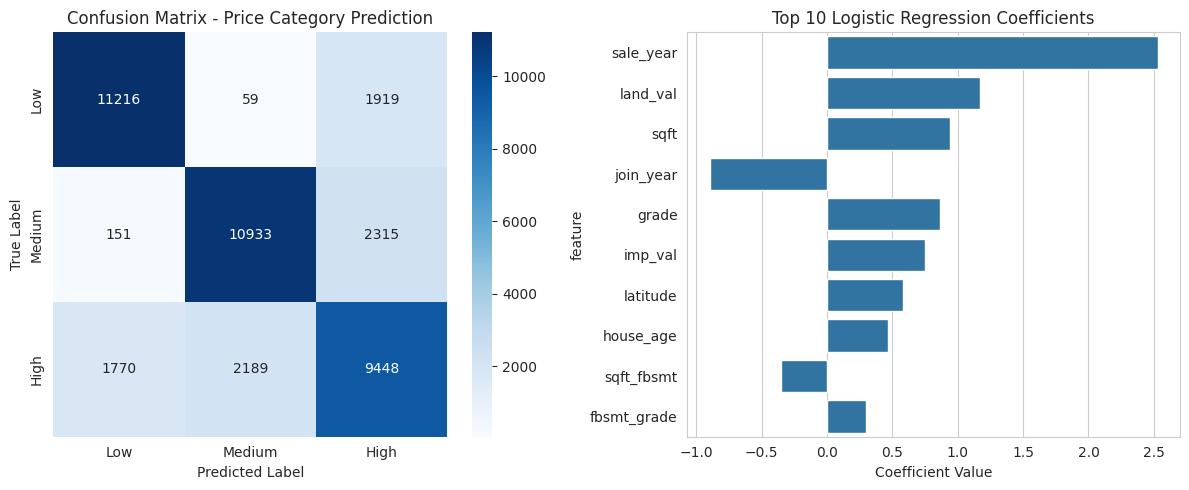


Top Features for Price Category Classification:
sale_year: 2.5289
land_val: 1.1690
sqft: 0.9410
join_year: -0.8966
grade: 0.8617
imp_val: 0.7479
latitude: 0.5851
house_age: 0.4695
sqft_fbsmt: -0.3485
fbsmt_grade: 0.2988


In [25]:
# 6.1: Logistic Regression Analysis for Price Categories
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

if 'X' in locals() and not X.empty:
    print("=== Logistic Regression for Price Category Classification ===\n")

    # Create price categories based on quantiles
    price_quantiles = np.quantile(y, [0.33, 0.67])
    y_categorical = pd.cut(y,
                          bins=[-np.inf, price_quantiles[0], price_quantiles[1], np.inf],
                          labels=['Low', 'Medium', 'High'])

    # Prepare data for logistic regression
    X_lr = X[numerical_features].copy()  # Use only numerical features for simplicity
    X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(
        X_lr, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
    )

    # Train logistic regression model
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_lr_train, y_lr_train)

    # Predictions and evaluation
    y_lr_pred = lr_model.predict(X_lr_test)
    y_lr_proba = lr_model.predict_proba(X_lr_test)

    # Classification metrics
    print("Classification Report:")
    print(classification_report(y_lr_test, y_lr_pred))

    # Confusion Matrix
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_lr_test, y_lr_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title('Confusion Matrix - Price Category Prediction')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Feature coefficients
    plt.subplot(1, 2, 2)
    feature_importance = pd.DataFrame({
        'feature': X_lr.columns,
        'coefficient': lr_model.coef_[0]  # For binary case, use [0]
    }).sort_values('coefficient', key=abs, ascending=False).head(10)

    sns.barplot(data=feature_importance, x='coefficient', y='feature')
    plt.title('Top 10 Logistic Regression Coefficients')
    plt.xlabel('Coefficient Value')

    plt.tight_layout()
    plt.show()

    # Feature importance analysis
    print("\nTop Features for Price Category Classification:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"{row['feature']}: {row['coefficient']:.4f}")

### 6.2 Advanced Feature Engineering Techniques
*Create sophisticated features using domain knowledge and ML techniques*

=== Advanced Feature Engineering Analysis ===

Available columns in enhanced sample: ['sale_nbr', 'sale_warning', 'join_status', 'join_year', 'latitude', 'longitude', 'area', 'city', 'zoning', 'subdivision', 'present_use', 'land_val', 'imp_val', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt', 'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt', 'golf', 'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics', 'view_cascades', 'view_territorial', 'view_skyline', 'view_sound', 'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other', 'submarket', 'sale_nbr_was_missing', 'sale_year', 'sale_month', 'sale_dayofyear', 'house_age', 'years_since_reno', 'was_renovated', 'sale_price', 'price_per_sqft', 'bath_bed_ratio', 'total_rooms', 'is_new_construction', 'age_category', 'size_category', 'luxury_score', 'total_views', 'has_premium_view', 'total_assessed_value', 'improvement_ratio']
New features found: ['bath_

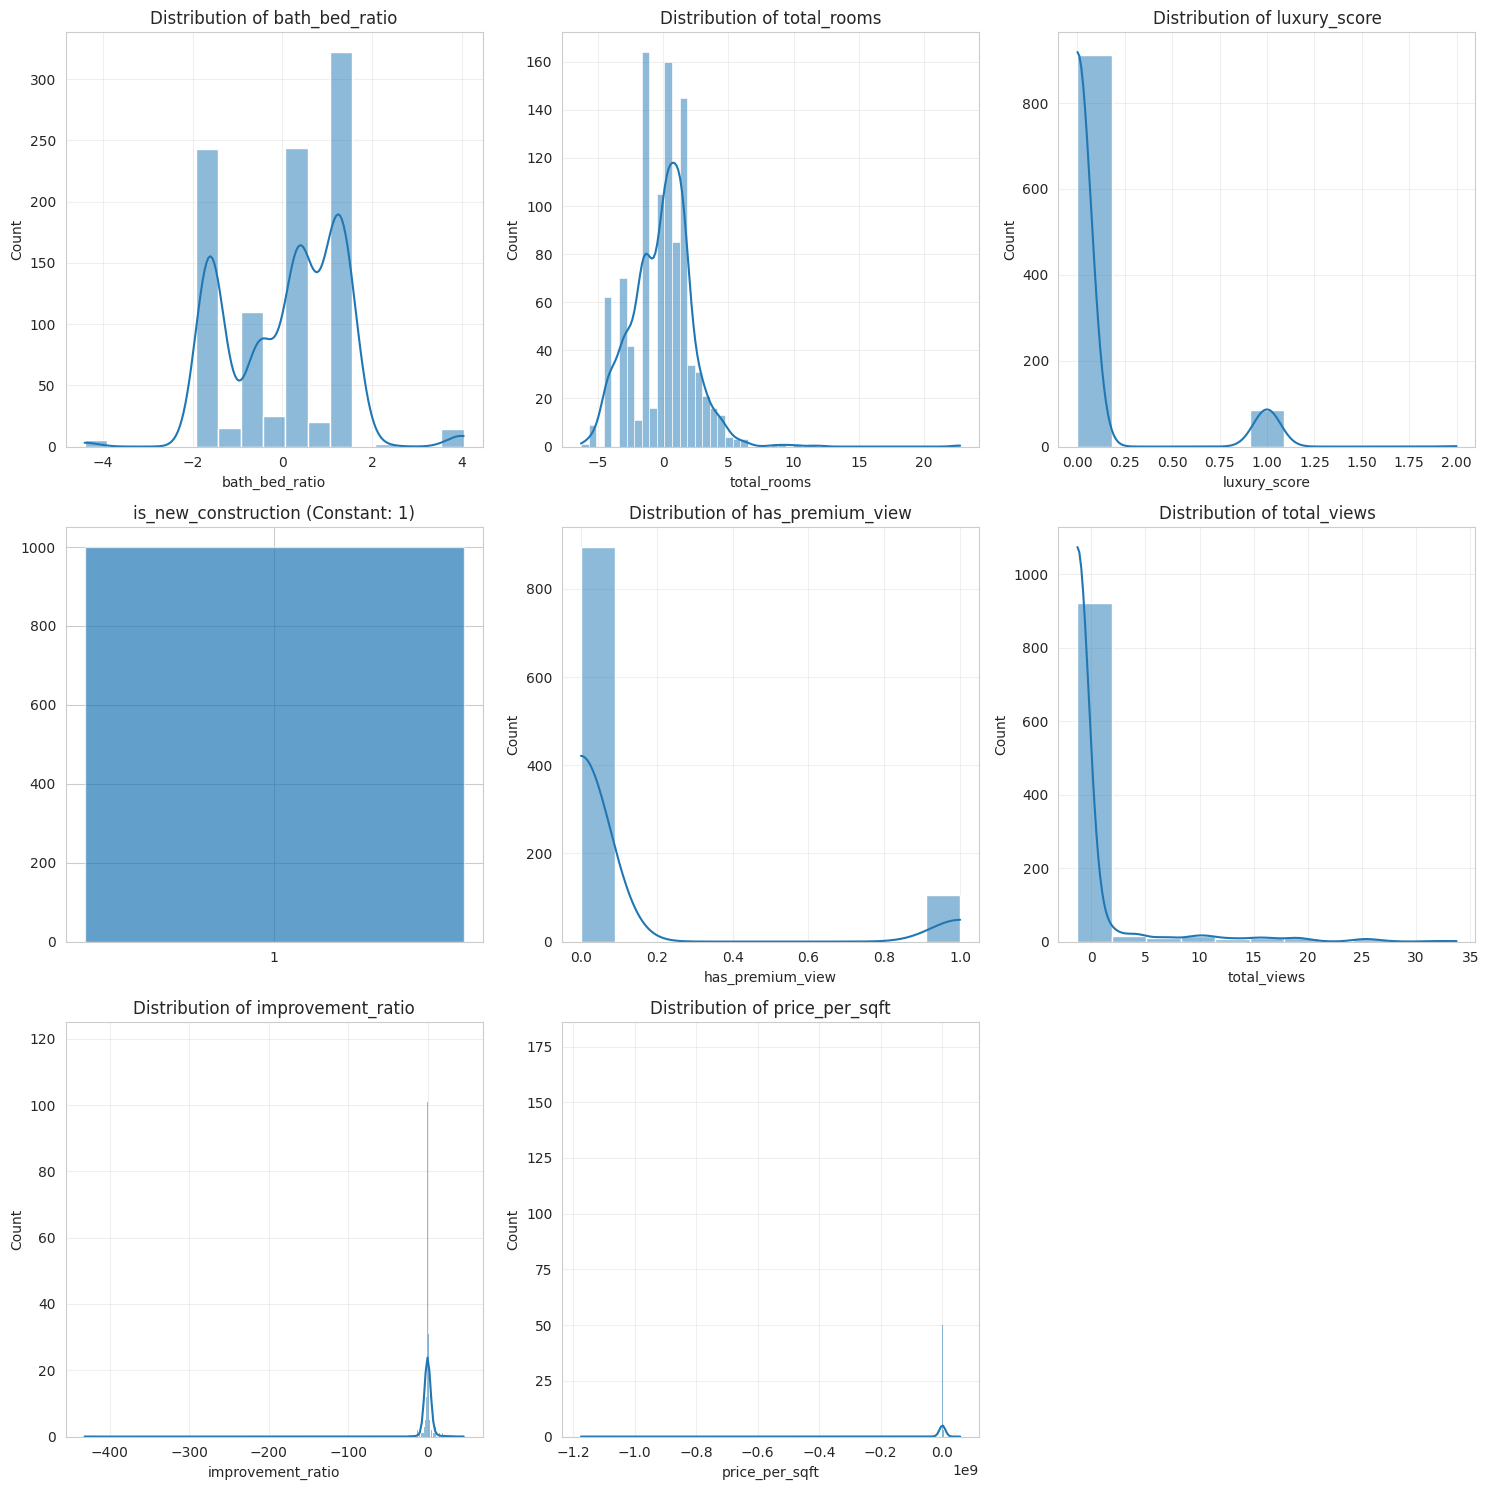


=== Advanced Feature Engineering Summary ===

bath_bed_ratio:
  Mean: 0.08
  Std: 1.26
  Min: -4.41
  Max: 4.04
  Unique Values: 27

total_rooms:
  Mean: -0.09
  Std: 2.34
  Min: -6.30
  Max: 22.78
  Unique Values: 89

luxury_score:
  Mean: 0.09
  Std: 0.29
  Min: 0.00
  Max: 2.00
  Unique Values: 3

is_new_construction:
  Mean: 1.00
  Std: 0.00
  Min: 1.00
  Max: 1.00
  Unique Values: 1

has_premium_view:
  Mean: 0.10
  Std: 0.31
  Min: 0.00
  Max: 1.00
  Unique Values: 2

total_views:
  Mean: -0.13
  Std: 4.22
  Min: -1.27
  Max: 33.73
  Unique Values: 57

improvement_ratio:
  Mean: -0.42
  Std: 14.34
  Min: -431.67
  Max: 45.26
  Unique Values: 994

price_per_sqft:
  Mean: -1045262.84
  Std: 37769499.91
  Min: -1175006543.49
  Max: 58145435.00
  Unique Values: 997

=== Correlation with Sale Price ===
bath_bed_ratio: 0.109
total_rooms: 0.293
luxury_score: 0.226
is_new_construction: No variation (constant)
has_premium_view: 0.215
total_views: 0.183
improvement_ratio: 0.042
price_per_

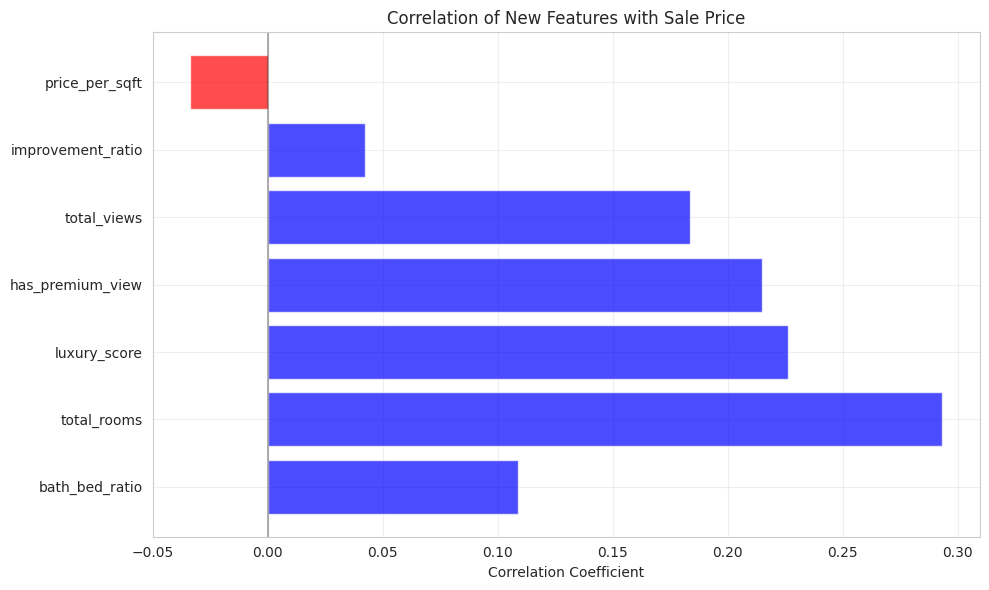

In [26]:
# 6.2: Advanced Feature Engineering
def advanced_feature_engineer(df):
    """Advanced feature engineering with domain knowledge"""
    df_copy = df.copy()

    # Price per square foot features (only if sale_price exists)
    if 'sqft' in df_copy.columns and 'sale_price' in df_copy.columns:
        df_copy['price_per_sqft'] = df_copy['sale_price'] / (df_copy['sqft'] + 1)

    # Bathroom to bedroom ratio - using correct column names
    if 'bath_full' in df_copy.columns and 'beds' in df_copy.columns:
        df_copy['bath_bed_ratio'] = df_copy['bath_full'] / (df_copy['beds'] + 1)

    # Total rooms feature - using correct column names
    room_cols = ['beds', 'bath_full', 'bath_3qtr', 'bath_half']
    available_room_cols = [col for col in room_cols if col in df_copy.columns]
    if available_room_cols:
        df_copy['total_rooms'] = df_copy[available_room_cols].sum(axis=1)

    # Age-related features (using house_age if available)
    if 'house_age' in df_copy.columns:
        df_copy['is_new_construction'] = (df_copy['house_age'] <= 5).astype(int)
        df_copy['age_category'] = pd.cut(df_copy['house_age'],
                                       bins=[-np.inf, 5, 20, 50, np.inf],
                                       labels=['New', 'Modern', 'Mature', 'Old'])

    # Size categories
    if 'sqft' in df_copy.columns:
        sqft_quantiles = df_copy['sqft'].quantile([0.25, 0.5, 0.75])
        df_copy['size_category'] = pd.cut(df_copy['sqft'],
                                        bins=[-np.inf] + sqft_quantiles.tolist() + [np.inf],
                                        labels=['Small', 'Medium', 'Large', 'XLarge'])

    # Luxury indicators - using correct column names
    luxury_indicators = []
    if 'bath_full' in df_copy.columns:
        luxury_indicators.append(df_copy['bath_full'] >= 2)
    if 'beds' in df_copy.columns:
        luxury_indicators.append(df_copy['beds'] >= 4)
    if 'stories' in df_copy.columns:
        luxury_indicators.append(df_copy['stories'] >= 2)
    if 'grade' in df_copy.columns:
        luxury_indicators.append(df_copy['grade'] >= 8)  # Assuming grade is numerical

    if luxury_indicators:
        df_copy['luxury_score'] = sum(luxury_indicators)

    # Location premium features
    if 'view_rainier' in df_copy.columns:
        view_cols = [col for col in df_copy.columns if col.startswith('view_')]
        if view_cols:
            df_copy['total_views'] = df_copy[view_cols].sum(axis=1)
            df_copy['has_premium_view'] = (df_copy['total_views'] > 0).astype(int)

    # Property value ratios
    if 'land_val' in df_copy.columns and 'imp_val' in df_copy.columns:
        df_copy['total_assessed_value'] = df_copy['land_val'] + df_copy['imp_val']
        df_copy['improvement_ratio'] = df_copy['imp_val'] / (df_copy['land_val'] + 1)

    return df_copy

# Apply advanced feature engineering - Use existing processed data instead of deleted train_df_raw
if 'X' in locals() and not X.empty:
    print("=== Advanced Feature Engineering Analysis ===\n")

    # Create a sample from existing processed data for demonstration
    # Reconstruct a sample with original scale data for visualization
    sample_size = min(1000, len(X))
    sample_indices = np.random.choice(len(X), sample_size, replace=False)

    # Create sample DataFrame with processed features
    enhanced_sample = X.iloc[sample_indices].copy()

    # Add back some original scale features for demonstration
    if 'y' in locals():
        enhanced_sample['sale_price'] = np.expm1(y.iloc[sample_indices])  # Convert back from log scale

    # Apply advanced feature engineering
    enhanced_features_sample = advanced_feature_engineer(enhanced_sample)

    # Visualize new features
    new_features = ['bath_bed_ratio', 'total_rooms', 'luxury_score', 'is_new_construction',
                   'has_premium_view', 'total_views', 'improvement_ratio', 'price_per_sqft']
    available_new_features = [col for col in new_features if col in enhanced_features_sample.columns]

    print(f"Available columns in enhanced sample: {list(enhanced_features_sample.columns)}")
    print(f"New features found: {available_new_features}")

    if available_new_features:
        n_features = len(available_new_features)
        n_cols = min(3, n_features)  # Use 3 columns max
        n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

        # Handle different subplot configurations
        if n_rows == 1 and n_cols == 1:
            axes = [axes]  # Single subplot case
        elif n_rows == 1:
            axes = axes.reshape(1, -1)  # Single row, multiple columns
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)  # Single column, multiple rows

        # Flatten axes array for easier indexing
        axes_flat = axes.flatten() if n_features > 1 else [axes[0]]

        for i, feature in enumerate(available_new_features):
            if i < len(axes_flat):  # Safety check
                ax = axes_flat[i]

                if enhanced_features_sample[feature].dtype in ['int64', 'float64', 'int8', 'int16', 'int32', 'float32']:
                    # Check if feature has enough variation for histogram
                    unique_values = enhanced_features_sample[feature].nunique()
                    if unique_values > 1:
                        sns.histplot(enhanced_features_sample[feature], kde=True, ax=ax)
                        ax.set_title(f'Distribution of {feature}')
                        ax.grid(True, alpha=0.3)
                    else:
                        # For features with no variation, show a bar chart
                        ax.bar([0], [len(enhanced_features_sample)], alpha=0.7)
                        ax.set_title(f'{feature} (Constant: {enhanced_features_sample[feature].iloc[0]})')
                        ax.set_xticks([0])
                        ax.set_xticklabels([enhanced_features_sample[feature].iloc[0]])
                else:
                    # For categorical features
                    value_counts = enhanced_features_sample[feature].value_counts()
                    if len(value_counts) > 0:
                        value_counts.plot(kind='bar', ax=ax)
                        ax.set_title(f'Distribution of {feature}')
                        ax.tick_params(axis='x', rotation=45)

        # Remove empty subplots if any
        for i in range(len(available_new_features), len(axes_flat)):
            axes_flat[i].set_visible(False)

        plt.tight_layout()
        plt.show()

        # Statistical summary
        print("\n=== Advanced Feature Engineering Summary ===")
        for feature in available_new_features:
            if enhanced_features_sample[feature].dtype in ['int64', 'float64', 'int8', 'int16', 'int32', 'float32']:
                try:
                    stats = enhanced_features_sample[feature].describe().round(2)
                    print(f"\n{feature}:")
                    print(f"  Mean: {stats['mean']:.2f}")
                    print(f"  Std: {stats['std']:.2f}")
                    print(f"  Min: {stats['min']:.2f}")
                    print(f"  Max: {stats['max']:.2f}")
                    print(f"  Unique Values: {enhanced_features_sample[feature].nunique()}")
                except:
                    print(f"\n{feature}: Could not compute statistics")
            else:
                print(f"\n{feature} (categorical):")
                print(enhanced_features_sample[feature].value_counts().head())

    # Feature correlation analysis with new features
    if 'sale_price' in enhanced_features_sample.columns and available_new_features:
        numerical_new_features = [f for f in available_new_features
                                if enhanced_features_sample[f].dtype in ['int64', 'float64', 'int8', 'int16', 'int32', 'float32']]

        if numerical_new_features:
            print(f"\n=== Correlation with Sale Price ===")
            correlations = {}
            for feature in numerical_new_features:
                try:
                    # Only calculate correlation if feature has variation
                    if enhanced_features_sample[feature].nunique() > 1:
                        corr = enhanced_features_sample[feature].corr(enhanced_features_sample['sale_price'])
                        correlations[feature] = corr
                        print(f"{feature}: {corr:.3f}")
                    else:
                        print(f"{feature}: No variation (constant)")
                except:
                    print(f"{feature}: Could not compute correlation")

            # Visualize correlations if we have any
            if correlations:
                plt.figure(figsize=(10, 6))
                features = list(correlations.keys())
                corr_values = list(correlations.values())

                # Filter out NaN correlations
                valid_corrs = [(f, v) for f, v in zip(features, corr_values) if not pd.isna(v)]

                if valid_corrs:
                    features_clean, corr_values_clean = zip(*valid_corrs)

                    colors = ['red' if x < 0 else 'blue' for x in corr_values_clean]
                    plt.barh(features_clean, corr_values_clean, color=colors, alpha=0.7)
                    plt.title('Correlation of New Features with Sale Price')
                    plt.xlabel('Correlation Coefficient')
                    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()

else:
    print("Processed data (X) not available. Please run the previous preprocessing steps first.")

## 7. Data Splitting for Conformal Prediction
*Split data into training and calibration sets for CQR methodology*

In [27]:
# 7: Data Splitting for Conformal Prediction
if 'X' in locals() and not X.empty:
    X_train_proper, X_calib, y_train_proper, y_calib = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data split into training and calibration sets.")

Data split into training and calibration sets.


## 8. Model Training (LightGBM, XGBoost, CatBoost)
*Train ensemble of quantile regression models for lower and upper bounds*

In [28]:
# 8: Model Training
# Train all 6 models (3 base models x 2 quantiles).
if 'X_train_proper' in locals():
    alpha = 0.1
    q_lower = alpha / 2.0
    q_upper = 1 - (alpha / 2.0)

    # --- LightGBM ---
    print("Training LightGBM models...")
    lgbm_params = {'objective': 'quantile', 'metric': 'quantile', 'random_state': 42, 'n_estimators': 1000}
    lgbm_lower = lgb.LGBMRegressor(alpha=q_lower, **lgbm_params)
    lgbm_upper = lgb.LGBMRegressor(alpha=q_upper, **lgbm_params)
    lgbm_lower.fit(X_train_proper, y_train_proper, categorical_feature=categorical_features, eval_set=[(X_calib, y_calib)], callbacks=[lgb.early_stopping(100, verbose=False)])
    lgbm_upper.fit(X_train_proper, y_train_proper, categorical_feature=categorical_features, eval_set=[(X_calib, y_calib)], callbacks=[lgb.early_stopping(100, verbose=False)])

    # --- XGBoost ---
    print("Training XGBoost models...")
    # Convert categorical features to integer codes for XGBoost
    X_train_xgb = X_train_proper.copy()
    X_calib_xgb = X_calib.copy()
    for col in categorical_features:
        X_train_xgb[col] = X_train_xgb[col].cat.codes
        X_calib_xgb[col] = X_calib_xgb[col].cat.codes
    xgb_params = {'objective': 'reg:quantileerror', 'random_state': 42, 'n_estimators': 1000, 'tree_method': 'hist'}
    xgb_lower = xgb.XGBRegressor(quantile_alpha=q_lower, **xgb_params)
    xgb_upper = xgb.XGBRegressor(quantile_alpha=q_upper, **xgb_params)
    # This simplified fit call is more robust across different environments.
    xgb_lower.fit(X_train_xgb, y_train_proper, eval_set=[(X_calib_xgb, y_calib)], verbose=False)
    xgb_upper.fit(X_train_xgb, y_train_proper, eval_set=[(X_calib_xgb, y_calib)], verbose=False)

    # --- CatBoost ---
    print("Training CatBoost models...")
    # Option 1: Disable logging completely by setting train_dir=None
    cat_params_lower = {'loss_function': f'Quantile:alpha={q_lower}', 'iterations': 1000, 'verbose': 0, 'random_seed': 42, 'train_dir': None}
    cat_params_upper = {'loss_function': f'Quantile:alpha={q_upper}', 'iterations': 1000, 'verbose': 0, 'random_seed': 42, 'train_dir': None}

    # Option 2: Or specify a custom directory (uncomment the lines below and comment out the ones above)
    # cat_params_lower = {'loss_function': f'Quantile:alpha={q_lower}', 'iterations': 1000, 'verbose': 0, 'random_seed': 42, 'train_dir': './ml_model/catboost_logs'}
    # cat_params_upper = {'loss_function': f'Quantile:alpha={q_upper}', 'iterations': 1000, 'verbose': 0, 'random_seed': 42, 'train_dir': './ml_model/catboost_logs'}

    cat_lower = cb.CatBoostRegressor(**cat_params_lower)
    cat_upper = cb.CatBoostRegressor(**cat_params_upper)

    cat_lower.fit(X_train_proper, y_train_proper, cat_features=categorical_features, eval_set=[(X_calib, y_calib)], early_stopping_rounds=100)
    cat_upper.fit(X_train_proper, y_train_proper, cat_features=categorical_features, eval_set=[(X_calib, y_calib)], early_stopping_rounds=100)

    print("All models trained.")

Training LightGBM models...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12001
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Start training from score 12.128117
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044716 second

## 9. Ensemble CQR Calibration and Evaluation
*Calibrate prediction intervals using conformal prediction framework*

In [29]:
# 9: Ensemble CQR Calibration and Evaluation
if 'lgbm_lower' in locals():
    # 1. Get predictions from all models on the calibration set
    lgbm_cal_preds_lower = lgbm_lower.predict(X_calib)
    lgbm_cal_preds_upper = lgbm_upper.predict(X_calib)
    xgb_cal_preds_lower = xgb_lower.predict(X_calib_xgb) # Use encoded data for XGBoost
    xgb_cal_preds_upper = xgb_upper.predict(X_calib_xgb) # Use encoded data for XGBoost
    cat_cal_preds_lower = cat_lower.predict(X_calib)
    cat_cal_preds_upper = cat_upper.predict(X_calib)

    # 2. Average the predictions to create the ensemble interval
    ensemble_cal_lower = np.mean([lgbm_cal_preds_lower, xgb_cal_preds_lower, cat_cal_preds_lower], axis=0)
    ensemble_cal_upper = np.mean([lgbm_cal_preds_upper, xgb_cal_preds_upper, cat_cal_preds_upper], axis=0)

    # 3. Calculate conformity scores for the ENSEMBLE
    conformity_scores = np.maximum(ensemble_cal_lower - y_calib, y_calib - ensemble_cal_upper)

    # 4. Calculate the correction term 'q'
    n_calib = len(X_calib)
    q_level = np.ceil((1 - alpha) * (n_calib + 1)) / n_calib
    q = np.quantile(conformity_scores, q_level, interpolation='higher')
    print(f"Calculated Ensemble CQR correction factor (q): {q:.4f}")

    # 5. Apply correction and evaluate
    final_lower_bound_log = ensemble_cal_lower - q
    final_upper_bound_log = ensemble_cal_upper + q

    y_calib_orig = np.expm1(y_calib)
    final_lower_bound_orig = np.expm1(final_lower_bound_log)
    final_upper_bound_orig = np.expm1(final_upper_bound_log)

    coverage = np.mean((y_calib_orig >= final_lower_bound_orig) & (y_calib_orig <= final_upper_bound_orig))
    winkler = mean_winkler_score(y_calib_orig, final_lower_bound_orig, final_upper_bound_orig)

    print(f"\nTarget Coverage: {1-alpha:.2f}")
    print(f"Ensemble Empirical Coverage on Hold-out Set: {coverage:.4f}")
    print(f"Ensemble Mean Winkler Score on Hold-out Set: {winkler:,.2f}")

Calculated Ensemble CQR correction factor (q): 0.0022

Target Coverage: 0.90
Ensemble Empirical Coverage on Hold-out Set: 0.9001
Ensemble Mean Winkler Score on Hold-out Set: 332,080.65


### 9.1 Model Accuracy Evaluation
*Evaluate model performance using multiple accuracy metrics*

In [30]:
# 9.1: Model Accuracy Evaluation on Calibration Set
from sklearn.metrics import r2_score
import numpy as np

if 'y_calib_orig' in locals():
    print("=== Model Accuracy Evaluation (Calibration Set) ===\n")

    # 1. Coverage Accuracy (Already calculated above, but showing again for clarity)
    coverage_accuracy = np.mean((y_calib_orig >= final_lower_bound_orig) & (y_calib_orig <= final_upper_bound_orig))
    print(f"Prediction Interval Coverage Accuracy: {round(coverage_accuracy * 100, 2)}%")
    print(f"Target Coverage: {round((1-alpha) * 100, 2)}% (90%)")

    # 2. R² Score (based on midpoint of prediction intervals)
    mid_pred = (final_lower_bound_orig + final_upper_bound_orig) / 2
    r2 = r2_score(y_calib_orig, mid_pred)
    print(f"R² Accuracy Estimate (Midpoint): {round(r2 * 100, 2)}%")

    # 3. Predictions within ±10% of true value
    within_10 = np.mean(
        (mid_pred >= y_calib_orig * 0.9) & (mid_pred <= y_calib_orig * 1.1)
    )
    print(f"Predictions within ±10% of actual sale price: {round(within_10 * 100, 2)}%")

    # 4. Predictions within ±5% of true value
    within_5 = np.mean(
        (mid_pred >= y_calib_orig * 0.95) & (mid_pred <= y_calib_orig * 1.05)
    )
    print(f"Predictions within ±5% of actual sale price: {round(within_5 * 100, 2)}%")

    # 5. Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_calib_orig - mid_pred) / y_calib_orig)) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {round(mape, 2)}%")

    # 6. Interval Width Statistics
    interval_widths = final_upper_bound_orig - final_lower_bound_orig
    avg_interval_width = np.mean(interval_widths)
    median_price = np.median(y_calib_orig)
    relative_width = (avg_interval_width / median_price) * 100

    print(f"\n=== Prediction Interval Statistics ===")
    print(f"Average Interval Width: ${avg_interval_width:,.2f}")
    print(f"Relative Width (% of median price): {round(relative_width, 2)}%")
    print(f"Median Sale Price: ${median_price:,.2f}")

else:
    print("Calibration data not available for accuracy evaluation.")

=== Model Accuracy Evaluation (Calibration Set) ===

Prediction Interval Coverage Accuracy: 90.0%
Target Coverage: 90.0% (90%)
R² Accuracy Estimate (Midpoint): 93.03%
Predictions within ±10% of actual sale price: 64.32%
Predictions within ±5% of actual sale price: 37.94%
Mean Absolute Percentage Error (MAPE): 10.77%

=== Prediction Interval Statistics ===
Average Interval Width: $246,358.96
Relative Width (% of median price): 54.14%
Median Sale Price: $455,000.00


## 10. Model Performance Visualization

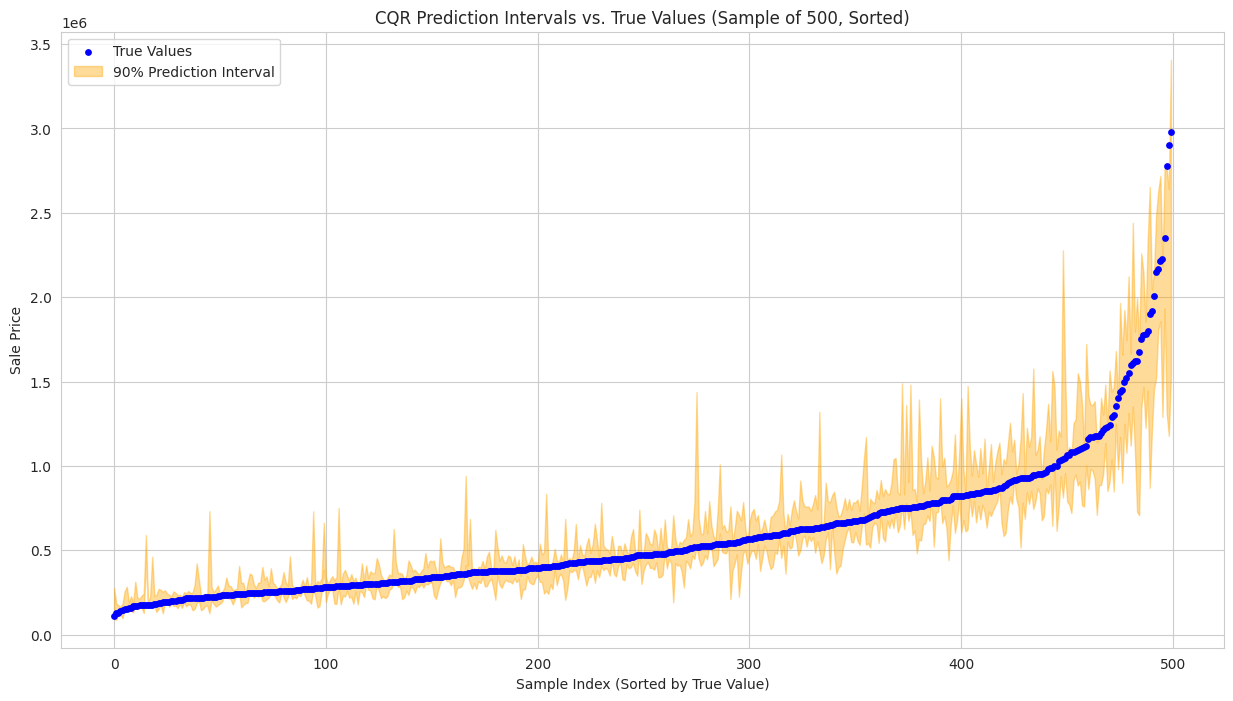

In [31]:
# 10: Model Performance Visualization
if 'y_calib_orig' in locals():
    # 10.1. Prediction Interval Visualization
    results_df = pd.DataFrame({
        'y_true': y_calib_orig,
        'lower': final_lower_bound_orig,
        'upper': final_upper_bound_orig
    }).sort_values('y_true').reset_index(drop=True)

    sample_results = results_df.sample(n=min(500, len(results_df)), random_state=42).sort_values('y_true')

    plt.figure(figsize=(15, 8))
    plt.scatter(range(len(sample_results)), sample_results['y_true'], color='blue', label='True Values', s=15, zorder=3)
    plt.fill_between(
        range(len(sample_results)),
        sample_results['lower'],
        sample_results['upper'],
        color='orange',
        alpha=0.4,
        label='90% Prediction Interval',
        zorder=1
    )
    plt.title('CQR Prediction Intervals vs. True Values (Sample of 500, Sorted)')
    plt.xlabel('Sample Index (Sorted by True Value)')
    plt.ylabel('Sale Price')
    plt.legend()
    plt.show()


### 10.2 Feature Importance Analysis
*Compare feature importance across different models*

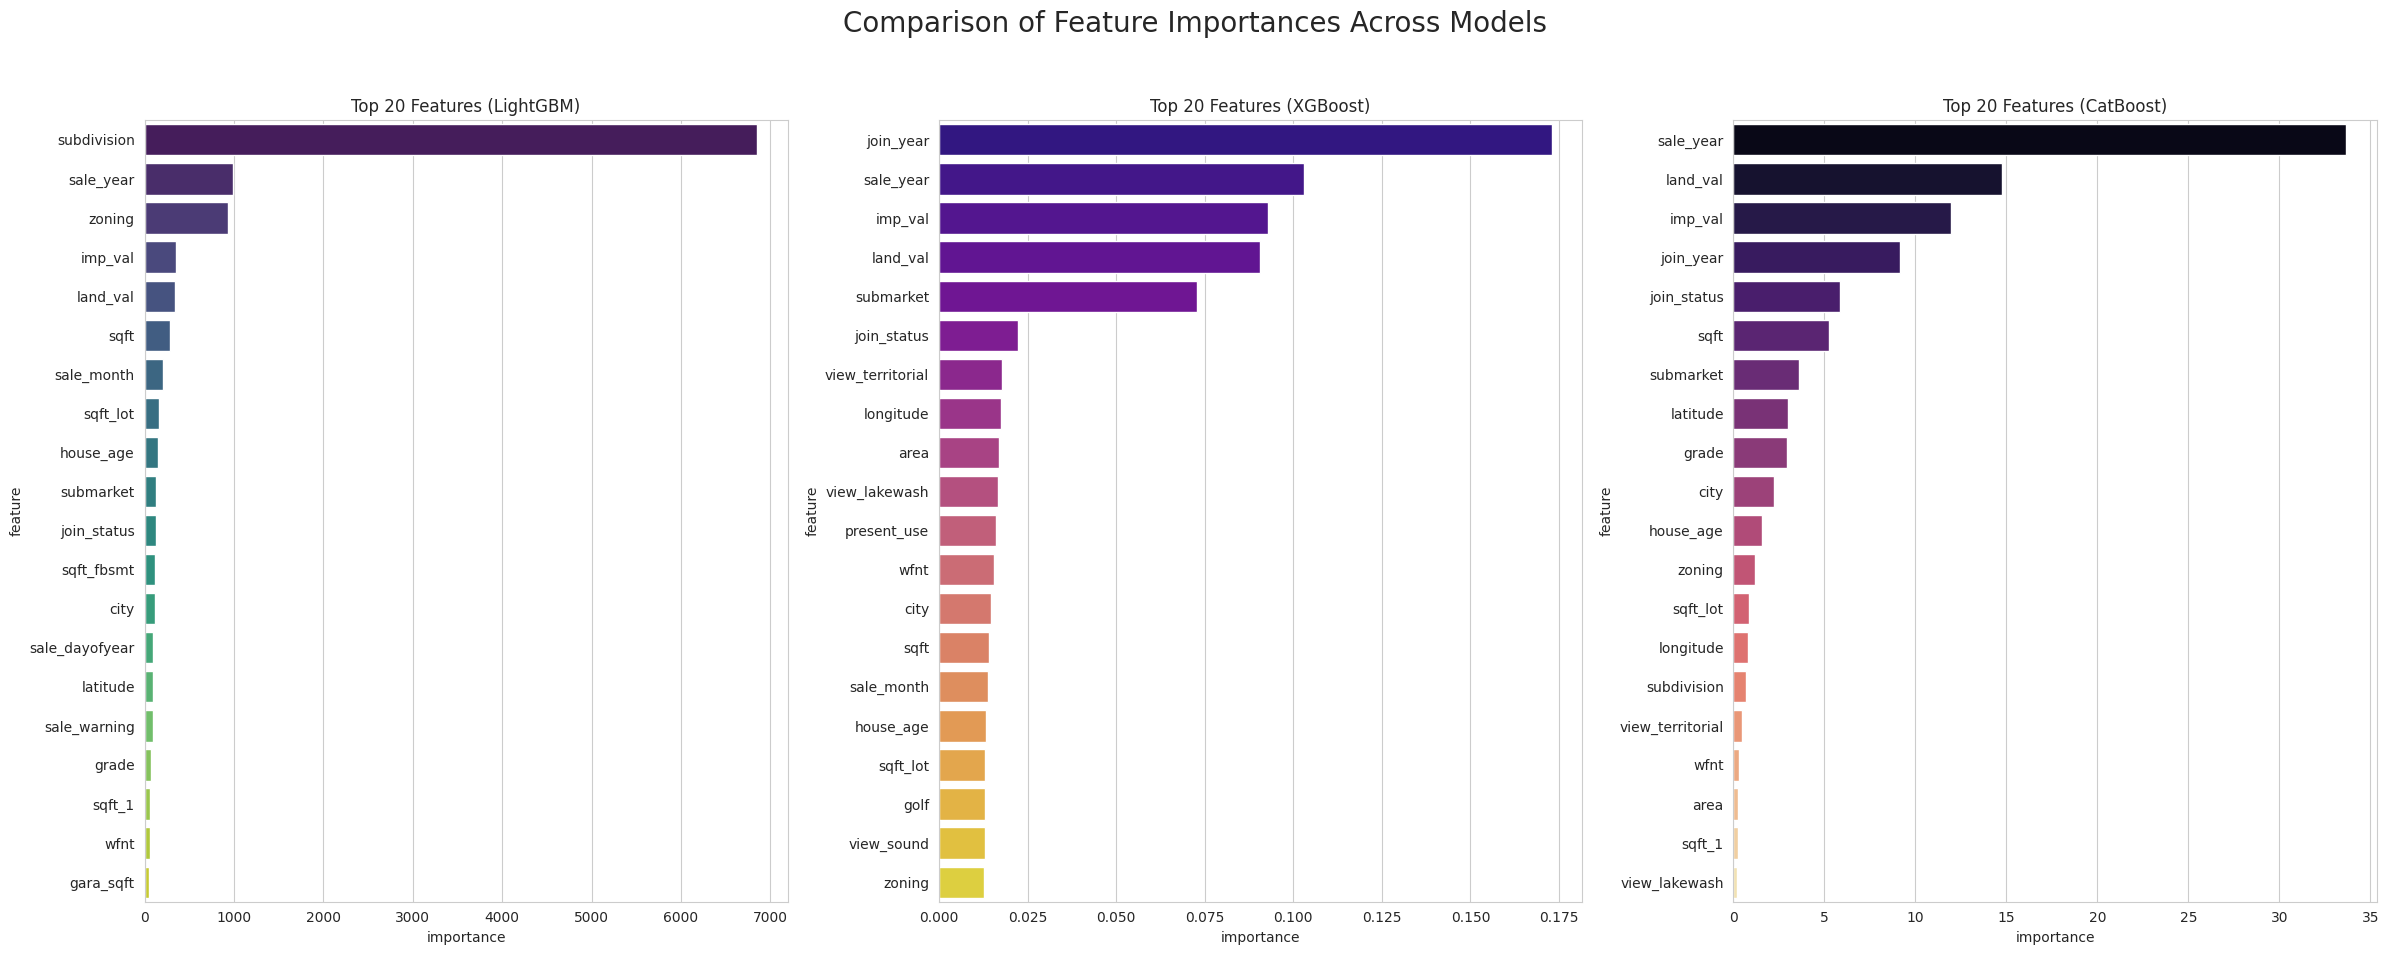

In [32]:

    # 10.2. Feature Importance Plots
    fig, axes = plt.subplots(1, 3, figsize=(24, 10))

    # LightGBM Feature Importance
    lgbm_importances = pd.DataFrame({'feature': X.columns, 'importance': lgbm_upper.feature_importances_}).sort_values('importance', ascending=False).head(20)
    sns.barplot(x='importance', y='feature', data=lgbm_importances, ax=axes[0], palette='viridis')
    axes[0].set_title('Top 20 Features (LightGBM)')

    # XGBoost Feature Importance
    xgb_importances = pd.DataFrame({'feature': X.columns, 'importance': xgb_upper.feature_importances_}).sort_values('importance', ascending=False).head(20)
    sns.barplot(x='importance', y='feature', data=xgb_importances, ax=axes[1], palette='plasma')
    axes[1].set_title('Top 20 Features (XGBoost)')

    # CatBoost Feature Importance
    cat_importances = pd.DataFrame({'feature': X.columns, 'importance': cat_upper.feature_importances_}).sort_values('importance', ascending=False).head(20)
    sns.barplot(x='importance', y='feature', data=cat_importances, ax=axes[2], palette='magma')
    axes[2].set_title('Top 20 Features (CatBoost)')

    plt.suptitle('Comparison of Feature Importances Across Models', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 10.3 Model Agreement Analysis
*Analyze prediction consistency between models*

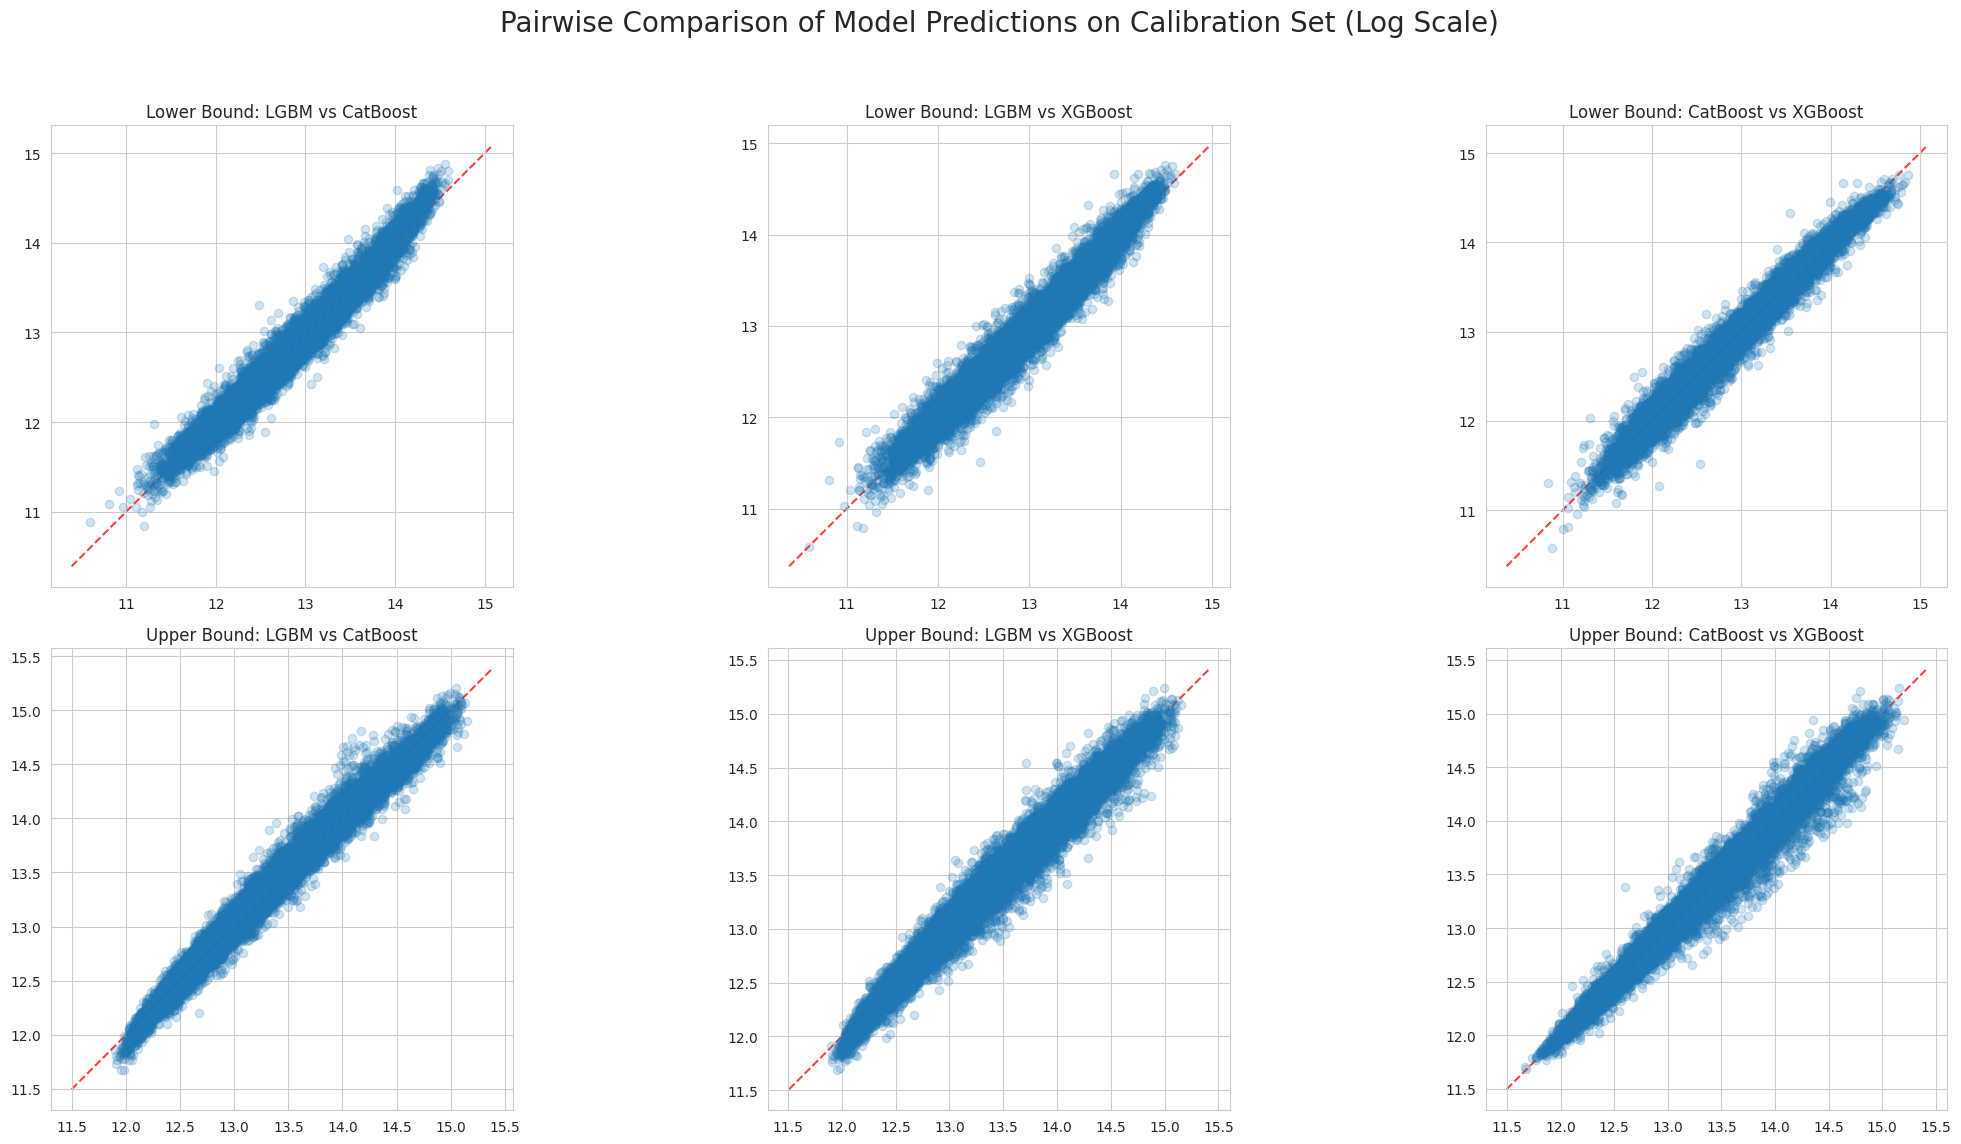

In [33]:
    # 10.3. Model Agreement Scatter Plots
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))

    # Lower Bound Comparisons
    axes[0, 0].scatter(lgbm_cal_preds_lower, cat_cal_preds_lower, alpha=0.2)
    axes[0, 0].set_title('Lower Bound: LGBM vs CatBoost')
    axes[0, 1].scatter(lgbm_cal_preds_lower, xgb_cal_preds_lower, alpha=0.2)
    axes[0, 1].set_title('Lower Bound: LGBM vs XGBoost')
    axes[0, 2].scatter(cat_cal_preds_lower, xgb_cal_preds_lower, alpha=0.2)
    axes[0, 2].set_title('Lower Bound: CatBoost vs XGBoost')

    # Upper Bound Comparisons
    axes[1, 0].scatter(lgbm_cal_preds_upper, cat_cal_preds_upper, alpha=0.2)
    axes[1, 0].set_title('Upper Bound: LGBM vs CatBoost')
    axes[1, 1].scatter(lgbm_cal_preds_upper, xgb_cal_preds_upper, alpha=0.2)
    axes[1, 1].set_title('Upper Bound: LGBM vs XGBoost')
    axes[1, 2].scatter(cat_cal_preds_upper, xgb_cal_preds_upper, alpha=0.2)
    axes[1, 2].set_title('Upper Bound: CatBoost vs XGBoost')

    for ax_row in axes:
        for ax in ax_row:
            lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),
                np.max([ax.get_xlim(), ax.get_ylim()]),
            ]
            ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
            ax.set_aspect('equal', adjustable='box')
            ax.grid(True)

    plt.suptitle('Pairwise Comparison of Model Predictions on Calibration Set (Log Scale)', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 10.4 Comprehensive Model Performance Comparison
*Compare all models across multiple evaluation metrics*

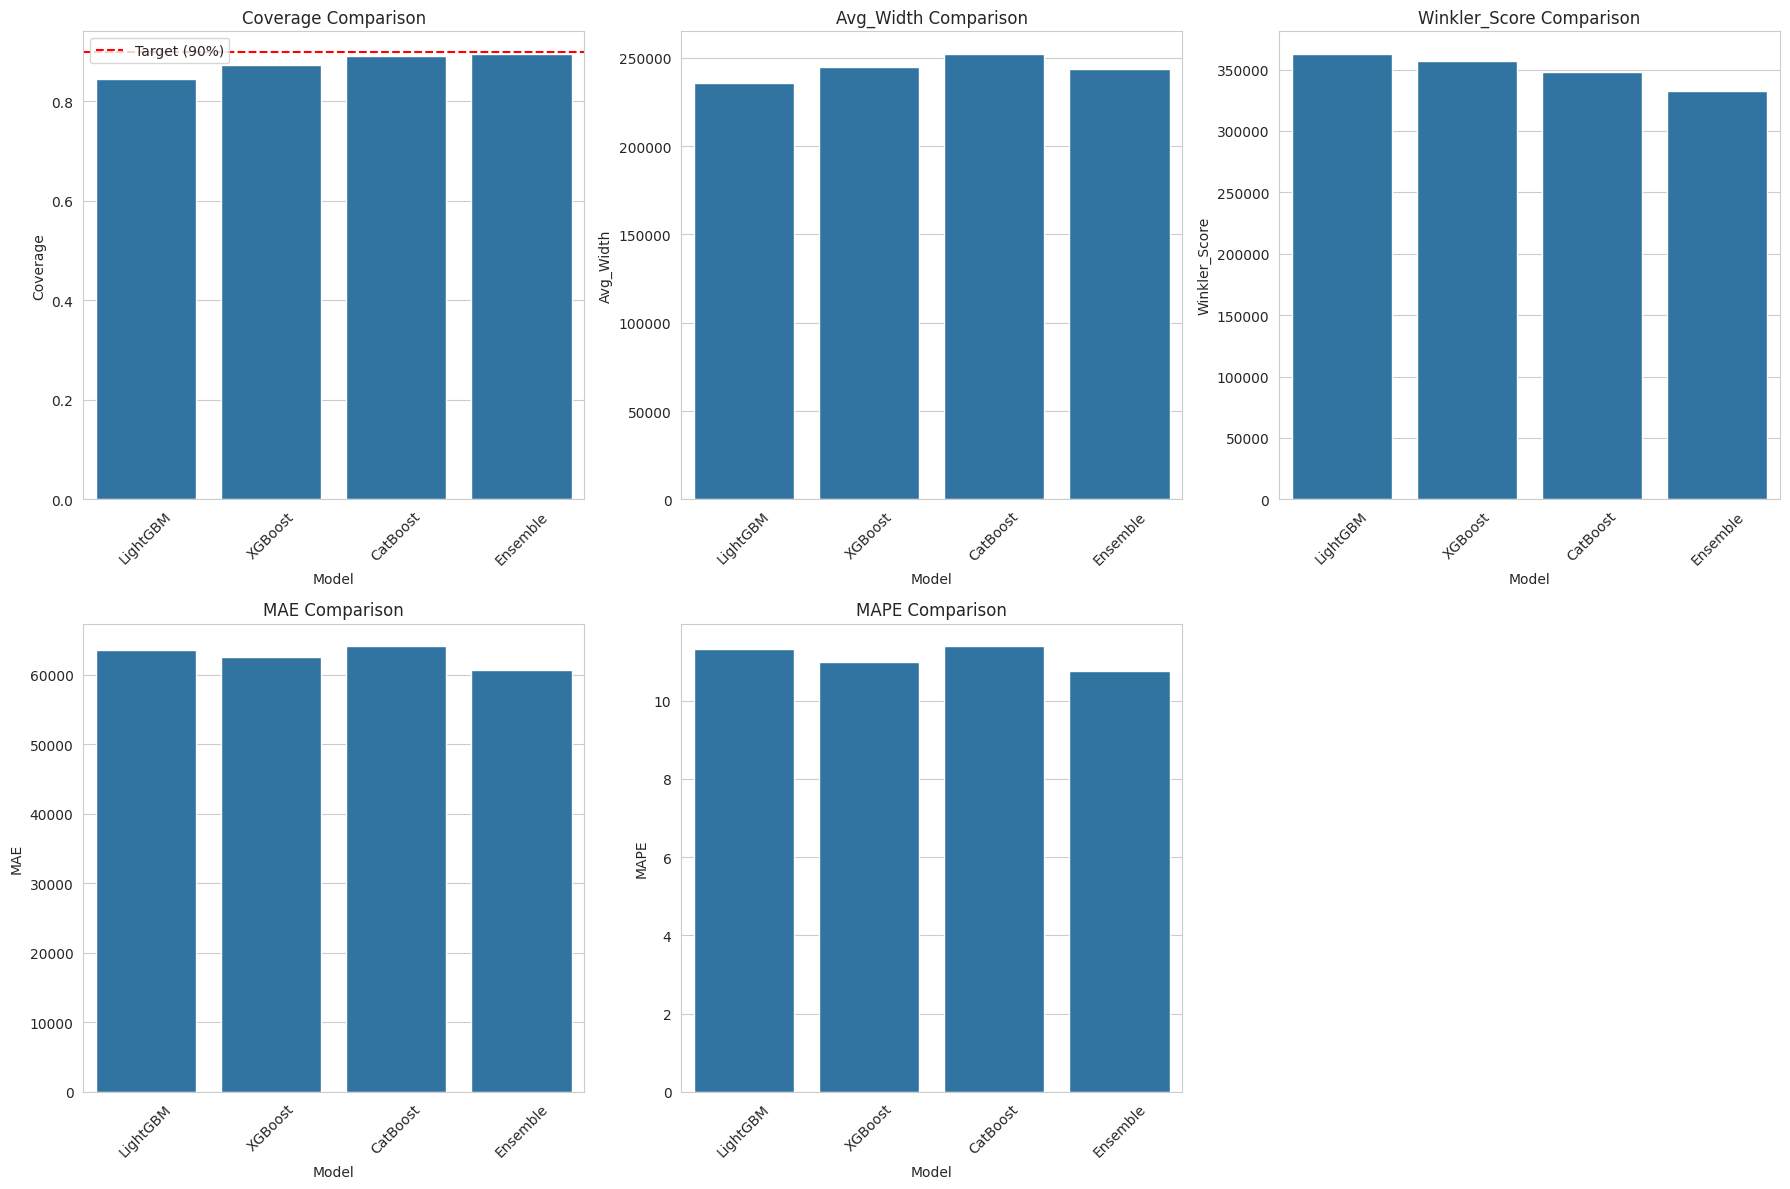

=== Comprehensive Model Performance Comparison ===
      Model  Coverage    Avg_Width  Winkler_Score         MAE     MAPE
0  LightGBM    0.8462  235618.5603    362995.2729  63603.1704  11.3145
1   XGBoost    0.8742  244575.7969    357152.1875  62564.2709  10.9854
2  CatBoost    0.8919  252394.5956    348192.8610  64143.1198  11.3929
3  Ensemble    0.8962  243791.7059    332165.4944  60655.4725  10.7643


In [34]:
# 10.4: Model Performance Comparison Dashboard
if 'y_calib_orig' in locals():
    # Calculate individual model predictions on calibration set
    models_comparison = {
        'LightGBM': {
            'lower': lgbm_cal_preds_lower,
            'upper': lgbm_cal_preds_upper
        },
        'XGBoost': {
            'lower': xgb_cal_preds_lower,
            'upper': xgb_cal_preds_upper
        },
        'CatBoost': {
            'lower': cat_cal_preds_lower,
            'upper': cat_cal_preds_upper
        },
        'Ensemble': {
            'lower': ensemble_cal_lower,
            'upper': ensemble_cal_upper
        }
    }

    # Performance metrics comparison
    performance_results = []

    for model_name, preds in models_comparison.items():
        # Convert to original scale
        lower_orig = np.expm1(preds['lower'])
        upper_orig = np.expm1(preds['upper'])

        # Calculate metrics
        coverage = np.mean((y_calib_orig >= lower_orig) & (y_calib_orig <= upper_orig))
        avg_width = np.mean(upper_orig - lower_orig)
        winkler = mean_winkler_score(y_calib_orig, lower_orig, upper_orig)

        # Midpoint accuracy
        midpoint = (lower_orig + upper_orig) / 2
        mae = np.mean(np.abs(y_calib_orig - midpoint))
        mape = np.mean(np.abs((y_calib_orig - midpoint) / y_calib_orig)) * 100

        performance_results.append({
            'Model': model_name,
            'Coverage': coverage,
            'Avg_Width': avg_width,
            'Winkler_Score': winkler,
            'MAE': mae,
            'MAPE': mape
        })

    results_df = pd.DataFrame(performance_results)

    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    metrics = ['Coverage', 'Avg_Width', 'Winkler_Score', 'MAE', 'MAPE']

    for i, metric in enumerate(metrics):
        row, col = i // 3, i % 3
        sns.barplot(data=results_df, x='Model', y=metric, ax=axes[row, col])
        axes[row, col].set_title(f'{metric} Comparison')
        axes[row, col].tick_params(axis='x', rotation=45)

        # Add target line for coverage
        if metric == 'Coverage':
            axes[row, col].axhline(y=0.9, color='red', linestyle='--', label='Target (90%)')
            axes[row, col].legend()

    # Remove empty subplot
    fig.delaxes(axes[1, 2])

    plt.tight_layout()
    plt.show()

    # Display results table
    print("=== Comprehensive Model Performance Comparison ===")
    print(results_df.round(4))

## 11. Final Model Training and Test Predictions
*Retrain models on full dataset and generate test predictions*

In [35]:
# 11: Final Training and Submission File Generation
if 'X' in locals():
    print("Retraining all models on the full dataset...")

    lgbm_params_final = {'objective': 'quantile', 'metric': 'quantile', 'random_state': 42, 'n_estimators': lgbm_lower.best_iteration_}
    final_lgbm_lower = lgb.LGBMRegressor(alpha=q_lower, **lgbm_params_final).fit(X, y, categorical_feature=categorical_features)
    lgbm_params_final['n_estimators'] = lgbm_upper.best_iteration_
    final_lgbm_upper = lgb.LGBMRegressor(alpha=q_upper, **lgbm_params_final).fit(X, y, categorical_feature=categorical_features)

    # Prepare full data for final XGBoost training
    X_xgb_full = X.copy()
    X_test_xgb = X_test.copy()
    for col in categorical_features:
        X_xgb_full[col] = X_xgb_full[col].cat.codes
        X_test_xgb[col] = X_test_xgb[col].cat.codes

    # Train final XGBoost models on the full encoded data
    xgb_params_final = {'objective': 'reg:quantileerror', 'random_state': 42, 'n_estimators': 1000, 'tree_method': 'hist'}
    final_xgb_lower = xgb.XGBRegressor(quantile_alpha=q_lower, **xgb_params_final).fit(X_xgb_full, y)
    final_xgb_upper = xgb.XGBRegressor(quantile_alpha=q_upper, **xgb_params_final).fit(X_xgb_full, y)

    # CatBoost final training with controlled logging
    cat_params_final_lower = {'loss_function': f'Quantile:alpha={q_lower}', 'iterations': cat_lower.get_best_iteration(), 'verbose': 0, 'random_seed': 42, 'train_dir': None}
    final_cat_lower = cb.CatBoostRegressor(**cat_params_final_lower).fit(X, y, cat_features=categorical_features)

    cat_params_final_upper = {'loss_function': f'Quantile:alpha={q_upper}', 'iterations': cat_upper.get_best_iteration(), 'verbose': 0, 'random_seed': 42, 'train_dir': None}
    final_cat_upper = cb.CatBoostRegressor(**cat_params_final_upper).fit(X, y, cat_features=categorical_features)

    print("Final model training complete.")

Retraining all models on the full dataset...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12534
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 49
[LightGBM] [Info] Start training from score 12.128117
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

In [36]:
    # --- Generate Submission ---
    print("Generating predictions for the test set...")
    lgbm_test_lower = final_lgbm_lower.predict(X_test)
    lgbm_test_upper = final_lgbm_upper.predict(X_test)
    xgb_test_lower = final_xgb_lower.predict(X_test_xgb)
    xgb_test_upper = final_xgb_upper.predict(X_test_xgb)
    cat_test_lower = final_cat_lower.predict(X_test)
    cat_test_upper = final_cat_upper.predict(X_test)

    # Ensemble the test predictions
    ensemble_test_lower = np.mean([lgbm_test_lower, xgb_test_lower, cat_test_lower], axis=0)
    ensemble_test_upper = np.mean([lgbm_test_upper, xgb_test_upper, cat_test_upper], axis=0)

    # Apply the correction factor 'q' found during calibration
    final_test_lower_log = ensemble_test_lower - q
    final_test_upper_log = ensemble_test_upper + q

    # Transform back to original scale
    final_test_lower_orig = np.expm1(final_test_lower_log)
    final_test_upper_orig = np.expm1(final_test_upper_log)

    # Post-processing
    final_test_lower_orig = np.maximum(0, final_test_lower_orig)
    final_test_upper_orig = np.maximum(final_test_lower_orig, final_test_upper_orig)

    # Create submission file
    test_df_ids = pd.read_csv(test_path, usecols=['id'])
    submission_df = pd.DataFrame({'id': test_df_ids['id'], 'pi_lower': final_test_lower_orig, 'pi_upper': final_test_upper_orig})

    submission_filename = '20282106_ensemble_submission-v6.csv'
    submission_df.to_csv(submission_filename, index=False)

    print(f"\nSubmission file '{submission_filename}' created successfully!")
    print(f"Saved to: {os.path.abspath(submission_filename)}")

    try:
        display(submission_df.head())
    except NameError:
        print(submission_df.head())

Generating predictions for the test set...

Submission file '20282106_ensemble_submission-v6.csv' created successfully!
Saved to: /content/20282106_ensemble_submission-v6.csv


,id,pi_lower,pi_upper
0,200000,793485.840953,1.104287e+06
1,200001,521370.859341,7.849734e+05
2,200002,386864.124951,6.487504e+05
3,200003,316350.442211,4.429738e+05
4,200004,383260.629010,7.818840e+05


## 12. Model Artifacts Export
*Save trained models, preprocessor, and configuration for deployment*

In [37]:
# 12: Save Models and Preprocessor for Application ---
import joblib
import json
import os

print("Saving models and artifacts....")

# Define the directory to save the artifacts
artifact_path = os.path.join(os.getcwd(), 'ml_model-artifacts')
os.makedirs(artifact_path, exist_ok=True)

# Save the 6 trained models
joblib.dump(final_lgbm_lower, os.path.join(artifact_path, 'lgbm_lower.pkl'))
joblib.dump(final_lgbm_upper, os.path.join(artifact_path, 'lgbm_upper.pkl'))
joblib.dump(final_xgb_lower, os.path.join(artifact_path, 'xgb_lower.pkl'))
joblib.dump(final_xgb_upper, os.path.join(artifact_path, 'xgb_upper.pkl'))
joblib.dump(final_cat_lower, os.path.join(artifact_path, 'cat_lower.pkl'))
joblib.dump(final_cat_upper, os.path.join(artifact_path, 'cat_upper.pkl'))

# Save the preprocessor pipeline
joblib.dump(preprocessor, os.path.join(artifact_path, 'preprocessor.pkl'))

# Save the feature lists and the 'q' value in a JSON file for easy loading
artifacts_to_save = {
    'q_value': q,
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'features_order': list(X.columns) # Save the exact order of columns
}

with open(os.path.join(artifact_path, 'model_config.json'), 'w') as f:
    json.dump(artifacts_to_save, f)

print(f"All artifacts saved to {artifact_path}")

Saving models and artifacts....
All artifacts saved to /content/ml_model-artifacts
